# lens modelling of DESJ2038-4008 with multiple options
This notebooks takes the data and psf configurations of the pre-analysis and configures (and runs) the lens modelling and parameter inference.
There are two modes:
    - local execution of a single model: this is mostly to test a model and having an output in a finite time.
    - cluster compute: it sends the configuration files to a cluster where the same models can be executed on multiple cores. This is the mode the results were produced.
    
In the second mode, the notebook initializes all the models that have been included in the analysis of Shajib et al. 2021.
In the last blocks of the notebook, some quick model inspections are performed.

### import libraries

In [1]:
import lenstronomy

lenstronomy.__version__

'1.9.0'

In [2]:
import numpy as np
import os
import pickle
import copy
import time
import h5py
from pprint import pprint
import joblib

import lenstronomy.Util.util as util
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Plots import chain_plot
from lenstronomy.Sampling.parameters import Param
from lenstronomy.Util import mask_util
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Util.util import array2image

cwd = os.getcwd()
base_path, _ = os.path.split(cwd)
print('Base directory path:', base_path)

Base directory path: /Users/ajshajib/Research/time_delay_cosmography/J2038/WGD2038-4008/lenstronomy_modeling


### plot settings

In [3]:
import matplotlib as mpl

# for MNRAS
mpl.rcParams['ps.fonttype'] = 42

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid, make_axes_locatable
import matplotlib.image as mpimg
import seaborn as sns
import coloripy as cp

# to change tex to Times New Roman in mpl
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['mathtext.it'] = 'serif:italic'
plt.rcParams['mathtext.bf'] = 'serif:bold'
plt.rcParams['mathtext.fontset'] = 'custom'


sns.set(style='ticks', context='paper', font='Times New Roman', font_scale=2.)
#sns.set_context('talk')
sns.set_style({"xtick.direction": "in","ytick.direction": "in", "axes.linewidth": 2.0,})
#sns.set_palette('Set2')

cmap = sns.cubehelix_palette(start=0.5, rot=-1.5, gamma=1, hue=1, light=-.6, dark=0.8, reverse=False, as_cmap=True)
cmap2 = sns.cubehelix_palette(start=0.5, rot=-1.5, gamma=1, hue=1, light=-.2, dark=1., reverse=False, as_cmap=True)

msh_cmap = cp.get_msh_cmap(num_bins=501, rescale='power', power=2.5)

## set up the Data() and PSF() class of lenstronomy

In [4]:
import h5py

def import_data(filter_name):
    data_file = os.path.join(base_path, 'data', 'data_{}.hdf5'.format(filter_name))
    f = h5py.File(data_file, 'r')
    
    data_reduced = f['image_data'][()]
    background_rms = f['background_rms'][()]
    exposure_map = f['exposure_map'][()]
    ra_at_xy_0 = f['ra_at_xy_0'][()]
    dec_at_xy_0 = f['dec_at_xy_0'][()]
    transform_pix2angle = f['transform_pix2angle'][()]
    f.close()

    kwargs_data = {'image_data': data_reduced, 
                    'background_rms': background_rms,
                    'noise_map': None,
                    'exposure_time': exposure_map,
                    'ra_at_xy_0': ra_at_xy_0,
                    'dec_at_xy_0': dec_at_xy_0, 
                    'transform_pix2angle': transform_pix2angle
                    }

    # get data and PSF estimate from file
    psf_file = os.path.join(base_path, 'data', 'psf_{}.hdf5'.format(filter_name))
    f = h5py.File(psf_file, 'r')
    kernel_point_source = f['kernel_point_source'][()]
    psf_error_map = f['psf_error_map'][()]
    f.close()


    kwargs_psf = {'psf_type': "PIXEL", 
                   'kernel_point_source': kernel_point_source ,
                   'kernel_point_source_init': kernel_point_source ,
                   'psf_error_map': psf_error_map,
                   }
    
    return kwargs_data, kwargs_psf

kwargs_data_f160w, kwargs_psf_f160w = import_data('f160w')
kwargs_data_f814w, kwargs_psf_f814w = import_data('f814w')
kwargs_data_f475x, kwargs_psf_f475x = import_data('f475x')

kwargs_data_f160w['ra_shift'], kwargs_data_f160w['dec_shift'] = 0.16715537453414964, -0.09043700974925503 #0.07512840424965349, 0.006380280266175261

## show image and initial guesses of point source coordinates

/Users/ajshajib/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


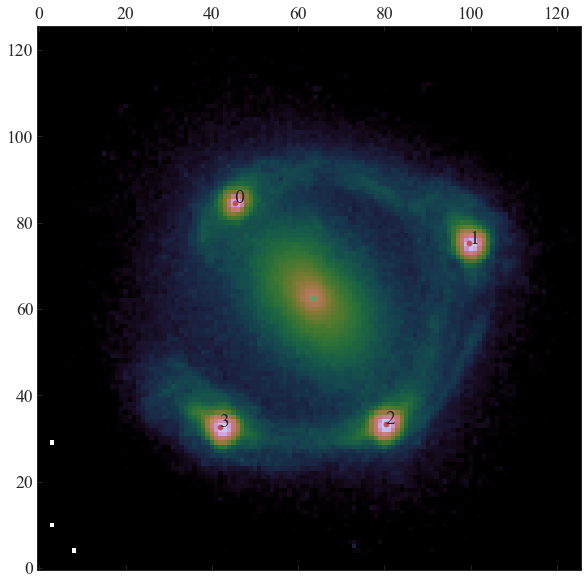

In [5]:
#%matplotlib notebook
%matplotlib inline 

# read-in the coordiante system of the exposure
ra_at_xy_0 = kwargs_data_f814w['ra_at_xy_0']
dec_at_xy_0 = kwargs_data_f814w['dec_at_xy_0']
transform_pix2angle = kwargs_data_f814w['transform_pix2angle']
coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)

# read-in the reduced cutout image
data_cutout = kwargs_data_f814w['image_data']
numPix = len(data_cutout)

ax = plt.figure(figsize=(10, 10)).add_subplot(111)
ax.matshow(np.log10(data_cutout), origin='lower', cmap=cmap, vmin=-3, vmax=1.)
ax.autoscale(False)

# estimate point source positions in (ra/dec)
im_pos_ra = np.array([ 0.70881968, -1.46828862, -0.69272039,  0.8476329 ])
im_pos_dec = np.array([ 0.86519289,  0.48675243, -1.18768461, -1.21536737])

lens_center_ra, lens_center_dec = -0.014271818911080656, -0.020882886550870693

x_at_radec_0, y_at_radec_0 = coords.map_coord2pix(0, 0)
x_image, y_image = coords.map_coord2pix(im_pos_ra, im_pos_dec)
ax.plot(x_image, y_image, 'or')

for i in range(len(x_image)):
    ax.text(x_image[i], y_image[i], i, fontsize=20)

lens_x, lens_y = coords.map_coord2pix(lens_center_ra, lens_center_dec)
ax.plot(lens_x, lens_y, 'og')    
#plt.colorbar()
plt.show()

Pixel size: 0.04 arcsec


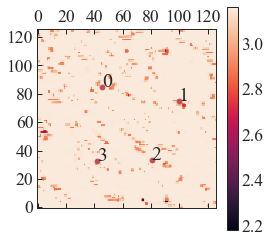

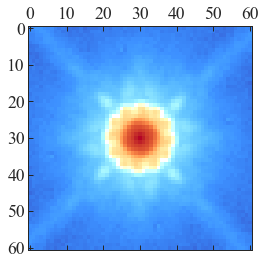

In [6]:
%matplotlib inline 

deltaPix = coords.pixel_width
print('Pixel size: {:.2f} arcsec'.format(deltaPix))
x_coords, y_coords = coords.coordinate_grid(numPix, numPix)
wht_map = kwargs_data_f814w['exposure_time']

plt.matshow(np.log10(wht_map), origin='lower')
plt.autoscale(False)

plt.plot(x_image,y_image,'or')
for i in range(len(x_image)):
    plt.text(x_image[i], y_image[i], i, fontsize=20)
plt.colorbar()
plt.show()


psf_kernel = kwargs_psf_f814w['kernel_point_source']
plt.matshow(np.log10(psf_kernel), vmin=-6, cmap=msh_cmap)
plt.show()

## set the masking regions used in the analysis

Create 1st set of masks.

/Users/ajshajib/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log10
/Users/ajshajib/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in log10


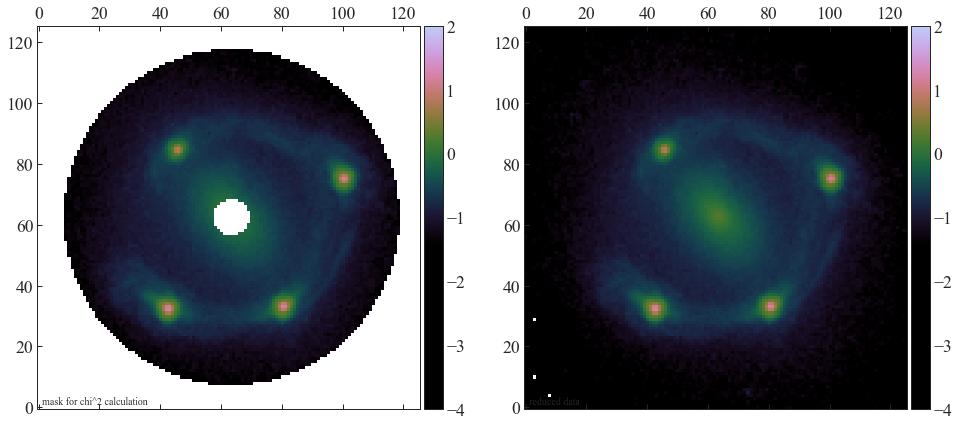

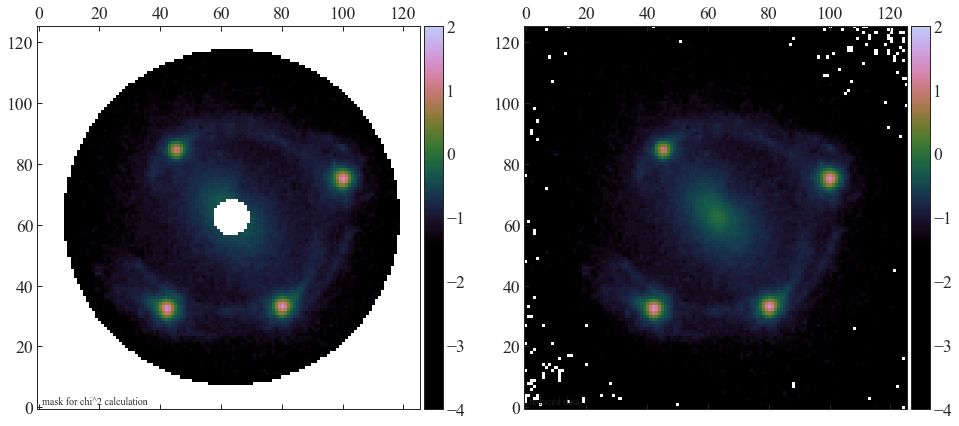

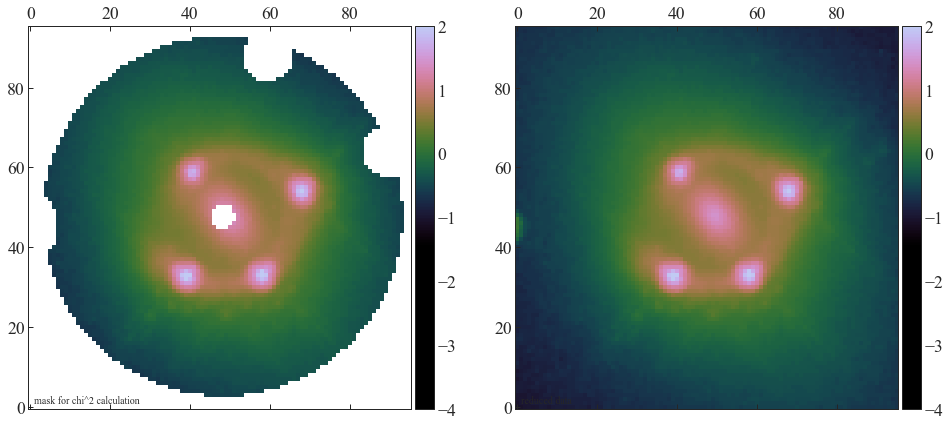

In [7]:
central_mask = True
central_mask_r = 0.24

r_mask_list = [
    [2.2], # f814w 
    [2.2], # f475x
    [3.6]  # f160w
    ]

mask_list = []
index_mask_list = []

for i in range(len(r_mask_list[0])):
    mask_bands = []
    index_mask_bands = []

    for j, kwargs_data in enumerate([kwargs_data_f814w, kwargs_data_f475x, kwargs_data_f160w]):
        ra_at_xy_0 = kwargs_data['ra_at_xy_0']
        dec_at_xy_0 = kwargs_data['dec_at_xy_0']
        transform_pix2angle = kwargs_data['transform_pix2angle']
        coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
        num_pix = len(kwargs_data['image_data'])

        x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)
        
        r = r_mask_list[j][i]
        
        mask_outer = mask_util.mask_center_2d(lens_center_ra, lens_center_dec, r, util.image2array(x_coords), util.image2array(y_coords))
        index_mask = 1 - mask_util.mask_center_2d(lens_center_ra, lens_center_dec, r+0.3, util.image2array(x_coords), util.image2array(y_coords))
        corona = mask_util.mask_center_2d(lens_center_ra, lens_center_dec, central_mask_r, util.image2array(x_coords), util.image2array(y_coords))
        
        mask_ext1 = 1 - mask_util.mask_center_2d(lens_center_ra-.28, lens_center_dec-5.3, .8, util.image2array(x_coords), util.image2array(y_coords))
        mask_ext2 = 1 - mask_util.mask_center_2d(lens_center_ra+4.32, lens_center_dec-2.6, .8, util.image2array(x_coords), util.image2array(y_coords))
        mask_ext3 = 1 - mask_util.mask_center_2d(lens_center_ra+4.1, lens_center_dec-0.2, .8, util.image2array(x_coords), util.image2array(y_coords))
        mask_ext4 = 1 - mask_util.mask_center_2d(lens_center_ra-8., lens_center_dec+1.1, 3., util.image2array(x_coords), util.image2array(y_coords))
        mask_ext5 = 1 - mask_util.mask_center_2d(lens_center_ra+7.6, lens_center_dec+2.7, 1., util.image2array(x_coords), util.image2array(y_coords))
        mask_ext6 = 1 - mask_util.mask_center_2d(lens_center_ra-2.8, lens_center_dec+6.2, 1., util.image2array(x_coords), util.image2array(y_coords))
        mask_ext7 = 1 - mask_util.mask_center_2d(lens_center_ra+4.9, lens_center_dec-5.2, 1., util.image2array(x_coords), util.image2array(y_coords))
        
        mask_ext8 = 1 - mask_util.mask_center_2d(lens_center_ra-3.3, lens_center_dec+1.3, .5, util.image2array(x_coords), util.image2array(y_coords))
        mask_ext9 = 1 - mask_util.mask_center_2d(lens_center_ra-.9, lens_center_dec+3.2, .5, util.image2array(x_coords), util.image2array(y_coords))

        mask = (1 - mask_outer) * (1- mask_ext1) * (1 - mask_ext2) * (1 - mask_ext3) * (1 - mask_ext4) \
                * (1 - mask_ext5) * (1 - mask_ext6) * (1 - mask_ext7) * (1 - mask_ext8) * (1 - mask_ext9)
        if central_mask:
            mask *= corona
            
        mask[mask >= 1] = 1
        mask[mask < 0] = 0
        
        mask_bands.append(array2image(mask))
        index_mask_bands.append(index_mask)
        
    mask_list.append(mask_bands)
    index_mask_list.append(index_mask_bands)
    

for j, kwargs_data in enumerate([kwargs_data_f814w, kwargs_data_f475x, kwargs_data_f160w]):
    image = kwargs_data['image_data']
    
    f, axes = plt.subplots(1, len(r_mask_list[0])+1, figsize=(16, 8), sharex=False, sharey=False)
    for i in range(len(r_mask_list[0])):
        ax = axes[i]
        
        mask = mask_list[0][j]
        
        im = ax.matshow(np.log10(image*mask), origin='lower', cmap=cmap, vmax=2, vmin=-4)
        ax.text(1, 1, 'mask for chi^2 calculation')
        ax.autoscale(False)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

        ax = axes[i+1]
        im = ax.matshow(np.log10(image), origin='lower', cmap=cmap, vmax=2, vmin=-4)
        ax.text(1, 1, 'reduced data')
        ax.autoscale(False)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

        plt.show()

Create 2nd set of masks.

/Users/ajshajib/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log10
/Users/ajshajib/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in log10


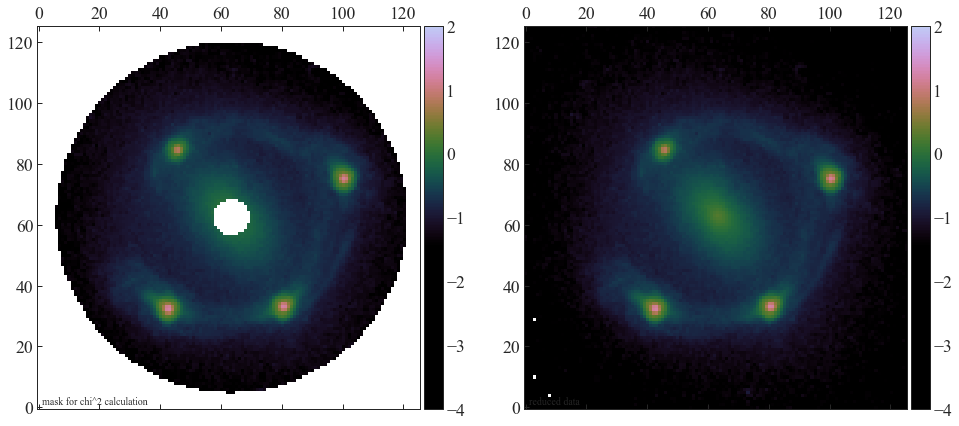

/Users/ajshajib/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in log10


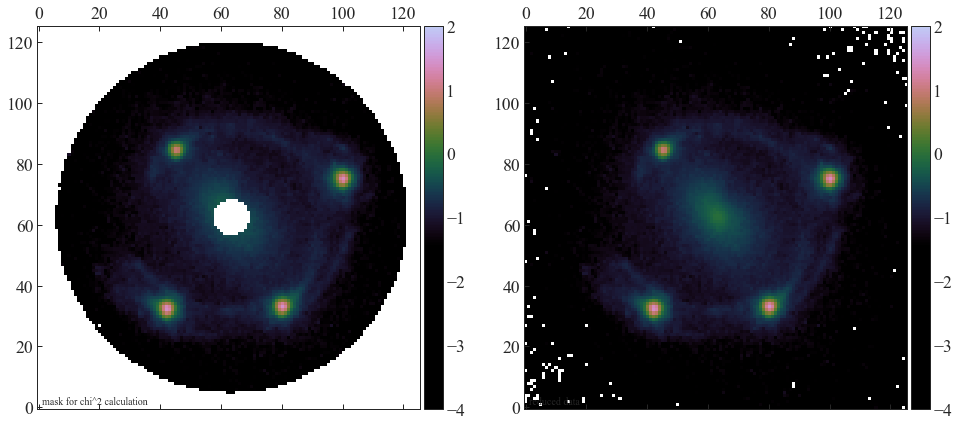

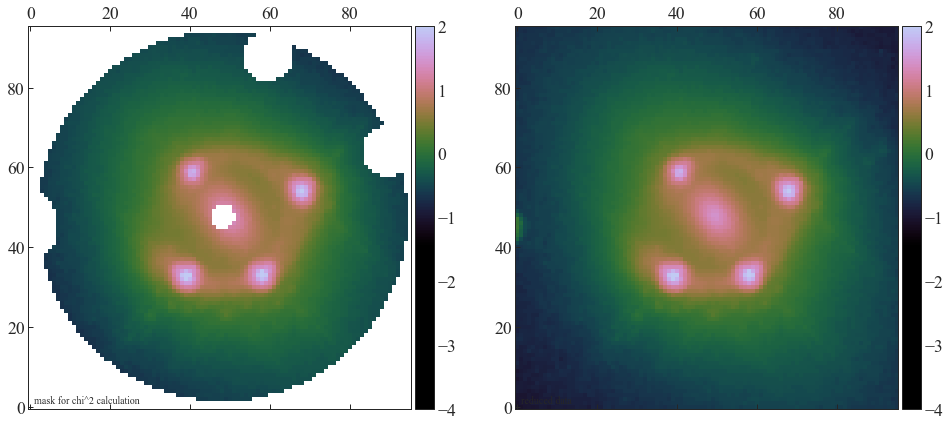

In [8]:
r_mask_list = [
    [2.3], # f814w 
    [2.3], # f475x
    [3.7]  # f160w
    ]

for i in range(len(r_mask_list[0])):
    mask_bands = []
    index_mask_bands = []

    for j, kwargs_data in enumerate([kwargs_data_f814w, kwargs_data_f475x, kwargs_data_f160w]):
        ra_at_xy_0 = kwargs_data['ra_at_xy_0']
        dec_at_xy_0 = kwargs_data['dec_at_xy_0']
        transform_pix2angle = kwargs_data['transform_pix2angle']
        coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
        num_pix = len(kwargs_data['image_data'])

        x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)
        
        r = r_mask_list[j][i]
        
        mask_outer = mask_util.mask_center_2d(lens_center_ra, lens_center_dec, r, util.image2array(x_coords), util.image2array(y_coords))
        index_mask = 1 - mask_util.mask_center_2d(lens_center_ra, lens_center_dec, r+0.3, util.image2array(x_coords), util.image2array(y_coords))
        corona = mask_util.mask_center_2d(lens_center_ra, lens_center_dec, central_mask_r, util.image2array(x_coords), util.image2array(y_coords))
        
        mask_ext1 = 1 - mask_util.mask_center_2d(lens_center_ra-.28, lens_center_dec-5.3, .8, util.image2array(x_coords), util.image2array(y_coords))
        mask_ext2 = 1 - mask_util.mask_center_2d(lens_center_ra+4.32, lens_center_dec-2.6, .8, util.image2array(x_coords), util.image2array(y_coords))
        mask_ext3 = 1 - mask_util.mask_center_2d(lens_center_ra+4.1, lens_center_dec-0.2, .8, util.image2array(x_coords), util.image2array(y_coords))
        mask_ext4 = 1 - mask_util.mask_center_2d(lens_center_ra-8., lens_center_dec+1.1, 3., util.image2array(x_coords), util.image2array(y_coords))
        mask_ext5 = 1 - mask_util.mask_center_2d(lens_center_ra+7.6, lens_center_dec+2.7, 1., util.image2array(x_coords), util.image2array(y_coords))
        mask_ext6 = 1 - mask_util.mask_center_2d(lens_center_ra-2.8, lens_center_dec+6.2, 1., util.image2array(x_coords), util.image2array(y_coords))
        mask_ext7 = 1 - mask_util.mask_center_2d(lens_center_ra+4.9, lens_center_dec-5.2, 1., util.image2array(x_coords), util.image2array(y_coords))
        
        mask_ext8 = 1 - mask_util.mask_center_2d(lens_center_ra-3.3, lens_center_dec+1.3, .5, util.image2array(x_coords), util.image2array(y_coords))
        mask_ext9 = 1 - mask_util.mask_center_2d(lens_center_ra-.9, lens_center_dec+3.2, .5, util.image2array(x_coords), util.image2array(y_coords))

        mask = (1 - mask_outer) * (1- mask_ext1) * (1 - mask_ext2) * (1 - mask_ext3) * (1 - mask_ext4) \
                * (1 - mask_ext5) * (1 - mask_ext6) * (1 - mask_ext7) * (1 - mask_ext8) * (1 - mask_ext9)
        
        if central_mask:
            mask *= corona
        
        mask[mask >= 1] = 1
        mask[mask < 0] = 0
        
        mask_bands.append(array2image(mask))
        index_mask_bands.append(index_mask)
        
    mask_list.append(mask_bands)
    index_mask_list.append(index_mask_bands)
    

for j, kwargs_data in enumerate([kwargs_data_f814w, kwargs_data_f475x, kwargs_data_f160w]):
    image = kwargs_data['image_data']
    
    f, axes = plt.subplots(1, len(r_mask_list[0])+1, figsize=(16, 8), sharex=False, sharey=False)
    for i in range(len(r_mask_list[0])):
        ax = axes[i]
        
        mask = mask_list[1][j]
        
        im = ax.matshow(np.log10(image*mask), origin='lower', cmap=cmap, vmax=2, vmin=-4)
        ax.text(1, 1, 'mask for chi^2 calculation')
        ax.autoscale(False)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

        ax = axes[i+1]
        im = ax.matshow(np.log10(image), origin='lower', cmap=cmap, vmax=2, vmin=-4)
        ax.text(1, 1, 'reduced data')
        ax.autoscale(False)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

        plt.show()

## set up supersampling mask

The pixels excluded by the supersampling mask will be supersampled with a factor 3 when creating the model-based image in the likelihood computation. Other pixels with low S/N will be sampled only once. This helps speed up the model optimization/MCMC.

/Users/ajshajib/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log10


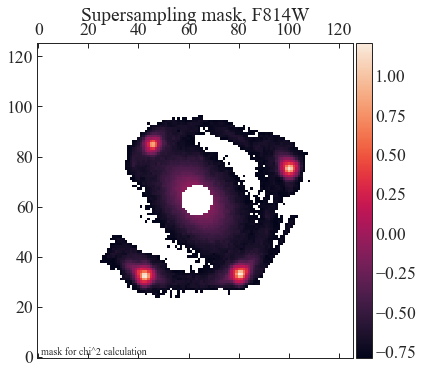

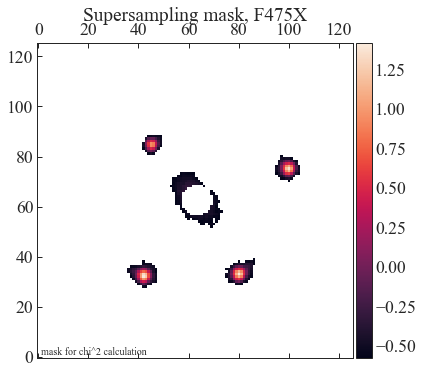

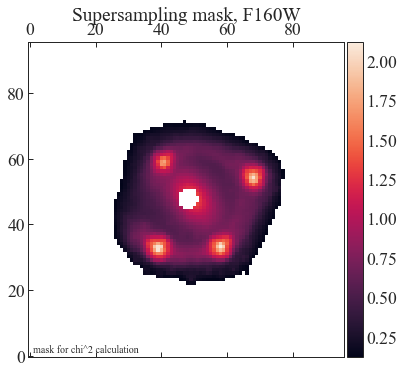

In [9]:
threshold = 10**(5/2.5) 
# pixels with flux > max_flux/threshold will not be supersampled
# here th threshold accepts pixels within 5 magnitude from the pixel with max_flux

supersampling_mask = []

for j, kwargs_data in enumerate([kwargs_data_f814w, kwargs_data_f475x, kwargs_data_f160w]):
    s_mask = np.ones_like(kwargs_data['image_data'])
    
    max_flux = np.max(kwargs_data['image_data'])
    s_mask[kwargs_data['image_data'] < max_flux/threshold] = 0
    
    supersampling_mask.append(s_mask)

filters = ['F814W', 'F475X', 'F160W']

for j, kwargs_data in enumerate([kwargs_data_f814w, kwargs_data_f475x, kwargs_data_f160w]):
    image = kwargs_data['image_data']
    
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)

    mask = supersampling_mask[j]*mask_list[0][j]
    im = ax.matshow(np.log10(image*mask), origin='lower')
    ax.text(1, 1, 'mask for chi^2 calculation')
    ax.autoscale(False)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ax.set_title("Supersampling mask, "+filters[j])
    plt.colorbar(im, cax=cax)

    plt.show()

## Prior specifications for NFW scale radius $R_{\rm s}$ and stellar mass

In [10]:
## NFW R_s prior based on Gavazzi et al. (2007)
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3, Ob0=0.05) # define cosmology #wCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3, Ode0=0.7, Ob0=0.05, w0=-1.5) #FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.4, Ob0=0.05) # define cosmology

z_l = 0.230

D_d_nfw = cosmo.angular_diameter_distance(z_l).value

r_s_prior_mu = 58./.7 / D_d_nfw*1e-3 * 206265.
r_s_prior_sigma = 8./.7 / D_d_nfw*1e-3 * 206265.

print('NFW R_s mean: {:.2f} arcsec, sigma: {:.2f} arcsec'.format(r_s_prior_mu, r_s_prior_sigma))
print('R_s -5sigma limit: {:.2f} arcsec, +5sigma limit: {:.2f} arcsec'.format(r_s_prior_mu-5*r_s_prior_sigma, 
                                                                r_s_prior_mu+5*r_s_prior_sigma))

NFW R_s mean: 22.55 arcsec, sigma: 3.11 arcsec
R_s -5sigma limit: 7.00 arcsec, +5sigma limit: 38.10 arcsec


In [11]:
from astropy.cosmology import FlatLambdaCDM
from lenstronomy.Cosmo.lens_cosmo import LensCosmo

samples = []

h = np.random.uniform(60, 80, 1000) #loc=70, scale=70*0.15, size=1000)

# for i in range(1000):
#     cosmo = FlatLambdaCDM(H0=np.abs(h[i]), Om0=np.random.uniform(0.05, 0.5))
#     lens_cosmo = LensCosmo(z_lens=0.230, z_source=0.777, cosmo=cosmo)
#     samples.append(np.log10(np.pi * (3.2/206265 * lens_cosmo.dd)**2 
#                                 * lens_cosmo.sigma_crit * 2))
    
# SPS-based stellar mass scales as M_{SPS} ~ 1/H_0^2
# Strong lensing stellar mass scales M_{SL} ~ 1/H_0
# So, the log(ratio) will be shifted by ±log_10(H_0)
samples = np.log10(h)
    
print('Additional stellar mass uncertainty accounting for ±10 km/s in H_0: ±{:.2f} dex'.format((np.max(samples) - np.min(samples))/2))

Additional stellar mass uncertainty accounting for ±10 km/s in H_0: ±0.06 dex


Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


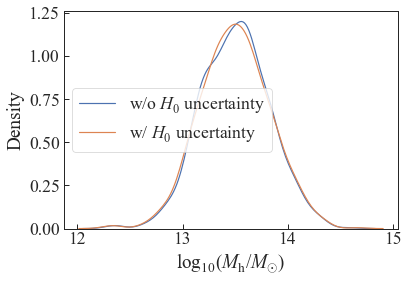

M_h mean: 13.5, std: 0.3


In [12]:
# Halo mass prior based on HSC weak lensing
# from Sonnenfeld et al. 2018
N = 1000

halo_mass_prior = (np.random.normal(13.11, 0.04, N)
                    + np.random.normal(1.43, 0.15, N) * (np.random.normal(11.57, 0.145, N) - 11.3)
                  ) + np.random.normal(0, np.abs(np.random.normal(0.23, 0.04, N)), N)

sns.kdeplot(halo_mass_prior, label=r'w/o $H_0$ uncertainty')
plt.xlabel(r'$\log_{10} (M_{\rm h}/ M_{\odot})$')


# ±10 uncertainty in H_0; M_200 \propto (excess shear)^(3/2) \propto \Sigma_crit^(3/2) \propto H_0^(3/2)
H0_uncertainty_distribution = np.random.uniform(60/70, 80/70, N)
halo_mass_prior = np.log10(10**halo_mass_prior * H0_uncertainty_distribution**(1.5))

sns.kdeplot(halo_mass_prior, label=r'w/ $H_0$ uncertainty')
plt.xlabel(r'$\log_{10} (M_{\rm h}/ M_{\odot})$')
plt.legend()
plt.show()

halo_mass_mean, halo_mass_std = np.mean(halo_mass_prior), np.std(halo_mass_prior)

print('M_h mean: {:.1f}, std: {:.1f}'.format(halo_mass_mean, halo_mass_std))

In [13]:
def custom_loglikelihood_addition(kwargs_lens=None, kwargs_source=None, 
                                 kwargs_lens_light=None, kwargs_ps=None, 
                                 kwargs_special=None, kwargs_extinction=None):
    """
    Impose a Gaussian prior on the NFW scale radius R_s based on Gavazzi et al. (2007).
    """
    pa_light = function(kwargs_lens_light) # in degree
    pa_mass = ...
    
    log_prior = -0.5 * (pa_light - pa_mass)**2 / sigma**2 - np.log(np.sqrt(np.pi*2) * sigma)
    
    return log_prior

    # imports inside function to avoid pickling 
    from colossus.halo import concentration
    from colossus.halo import mass_defs
    from colossus.cosmology import cosmology
    
    from lenstronomy.Cosmo.lens_cosmo import LensCosmo
    from lenstronomy.Analysis.lens_profile import LensProfileAnalysis
    from lenstronomy.LensModel.lens_model import LensModel


    lens_cosmo = LensCosmo(z_lens=0.230, z_source=0.777)
    lens_analysis = LensProfileAnalysis(
                            LensModel(lens_model_list=['NFW_ELLIPSE', 'SHEAR', 'TRIPLE_CHAMELEON'],
                            z_lens=0.230, z_source=0.777,
                            multi_plane=False, #True,
                            ))


    if kwargs_lens[0]['alpha_Rs'] < 0.:
        return -np.inf
    
    if not -0.014271818911080656-0.2 < kwargs_lens[0]['center_x'] < -0.014271818911080656+0.2:
        return -np.inf
    if not -0.020882886550870693-0.2 < kwargs_lens[0]['center_y'] < -0.020882886550870693+0.2:
        return -np.inf
    
    if not -0.5 < kwargs_lens[0]['e1'] < 0.5:
        return -np.inf
    if not -0.5 < kwargs_lens[0]['e2'] < 0.5:
        return -np.inf
    
    log_L = 0.
    
#     log_L += -0.5 * (kwargs_lens[0]['Rs'] - 22.6)**2 / 3.1**2
    
    # integrate upto 3.2 arcsec, which is half-light radius (~half-mass radius)
    mean_convergence = lens_analysis.mass_fraction_within_radius(kwargs_lens, 
                                                             kwargs_lens[2]['center_x'], 
                                                             kwargs_lens[2]['center_y'], 
                                                             3.2,
                                                             numPix=320)
    
    stellar_mass = np.log10(mean_convergence[2] * np.pi * (3.2/206265 * lens_cosmo.dd)**2 
                            * lens_cosmo.sigma_crit * 2) # multiplying by 2 to convert half-mass to full mass
    
    #log_L += - 0.5 * (stellar_mass - 11.40)**2 / (0.08**2 + 0.1**2)
    # adding 0.07 uncertainty in quadrature to account for 15% uncertainty in H_0, Om_0 ~ U(0.05, 0.5)
    high_sm = 11.57 + 0.25 + 0.06 # +0.06 is to add H_0 uncertainty
    low_sm = 11.57 - 0.06 # -0.06 is to add H_0 uncertainty
    if stellar_mass > high_sm:
        log_L += -0.5 * (high_sm - stellar_mass)**2 / (0.16**2)
    elif stellar_mass < low_sm:
        log_L += -0.5 * (low_sm - stellar_mass)**2 / (0.13**2)
    else:
        log_L += 0.
        
    _, _, c, r, halo_mass = lens_cosmo.nfw_angle2physical(kwargs_lens[0]['Rs'], kwargs_lens[0]['alpha_Rs'])
    log_L += -0.5 * (np.log10(halo_mass) - 13.5)**2 / 0.3**2
    
    my_cosmo = {'flat': True, 'H0': 70., 'Om0': 0.3, 'Ob0': 0.05, 
                'sigma8': 0.823, 'ns': 0.96} # fiducial cosmo
    cosmo = cosmology.setCosmology('my_cosmo', my_cosmo)

    c200 = concentration.concentration(halo_mass*cosmo.h, '200c', # input halo mass needs to be in M_sun/h unit
                                       0.23, model='diemer19')
    
    log_L += -0.5 * (np.log10(c) - np.log10(c200))**2 / (0.11**2)
            
    return log_L

In [14]:
ssh_command = 'ajshajib@hoffman2.idre.ucla.edu'
dir_path = os.getcwd()
dir_path_cluster = '/u/flashscratch/a/ajshajib/'

# numeric settings
band_number = 3

n_p_short = 10  # number of particles in the PSO (for tests)
n_i_short = 10 # number of iterations of the PSO (for tests)
n_p_medium = 48
n_i_medium = 100
n_p_long = 192  # number of particles in the PSO 
n_i_long = 200  # number of iterations of the PSO 

mcmc_n_burn = 0
mcmc_repeat = 2
mcmc_n_run = 1000 # the MCMC is performed in broken chunks, the next chunk is resumed from the last
walker_ratio = 8

psf_iteration = False  # bool, we perform an iterative PSF reconstruction
psf_iter_num = 50  # number of steps in the PSF reconstruction
psf_iter_factor = 0.5  # factor of f* new + (1-f)* old PSF in each iterative step
psf_symmetry = 4  # number of symmetry axis rotations

# lens model hyper-parameter settings
lens_bound = 0.2 # bound for lens position from the initial position
composite_type = 'TRIPLE_CHAMELEON'  # 'CHAMELEON', 'MGE', 'INTERPOL', 'DOUBLE_CHAMELEON'
mass_light_joint = True  # joint mass and light parameters in the composite model option

shear = True  # adding of a external shear component in the model

## lens light settings 

# templates for the lens light in three bands
power_law_lens_light_list = [['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE', 'SERSIC_ELLIPSE'],
                             ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE', 'SERSIC_ELLIPSE'],
                             ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE', 'SERSIC_ELLIPSE'],
                            ]
composite_lens_light_list = [['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE', 'SERSIC_ELLIPSE'],
                             ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE', 'SERSIC_ELLIPSE'],
                             [composite_type],
                            ]

## initial parameters for triple Chameleon profile
## Chameleon parameters are initiated from a good starting point to get
## faster convergence. These parameters are obtained from a triple-Sersic
## profile fits in `Convert Sersic to Chameleon for initial parameters.ipynb`.

# for setup with 'UNIFORM' profile
# cham_kwargs = [{'amp': 671.1816171202247,
#               'w_c': 0.07158021754988456,
#               'w_t': 1.8533443629531245,
#               'e1': -0.057563805326843805,
#               'e2': 0.22746815450245494,
#               'center_x': -0.0017282165494388127,
#               'center_y': -0.004350098722358016},
#              {'amp': -5.109762720282299,
#               'w_c': 8.662129579313662,
#               'w_t': 0.2958026803957224,
#               'e1': 0.16502863547411417,
#               'e2': -0.3814462037280518,
#               'center_x': -0.0016167767561703196,
#               'center_y': -0.0042140267638160036},
#              {'amp': 5.504933108099571,
#               'w_c': 0.882717602864708,
#               'w_t': 3.178291895888114,
#               'e1': -0.48735098807888255,
#               'e2': -0.2997966708399742,
#               'center_x': -0.0016589910187053076,
#               'center_y': -0.0040699792712868945}]

# for setup without 'UNIFORM' profile
cham_kwargs = [{'amp': 673.2640988996767,
                'w_c': 0.05931353027057668,
                'w_t': 0.5796519827045619,
                'e1': -0.07927713563923687,
                'e2': 0.29087280636467866,
                'center_x': 0.02798287882981844,
                'center_y': -0.04714050288570548},
               {'amp': 613.8381471319229,
                'w_c': 0.31591678251049216,
                'w_t': 6.2219079615305235,
                'e1': 0.02656806043341877,
                'e2': 0.04028725764835484,
                'center_x': 0.02814514289108032,
                'center_y': -0.04734816016482716},
               {'amp': 33.00503003414012,
                'w_c': 2.132218646769897,
                'w_t': 2.1322186467701614,
                'e1': -0.2710569909854522,
                'e2': 0.4564340906771116,
                'center_x': 0.02873678081704855,
                'center_y': -0.048953396113357875}]


# source settings
source_light_model_list_template = ['SERSIC_ELLIPSE'] # don't need to add shapelets as it's added inside the function
with_shapelets = True
shapelet_beta = 0.15 # initial guess of the shapelet scale (in arcsec)

# point source settings
point_source_model_list = ['LENSED_POSITION']  # we model the point sources in the image plane


def configure_model(job_name, deflector_model, mask, n_max_list, subgrid_res, 
                    cluster_compute=True, do_mcmc=True, use_good_start=False,
                    prev_job_name=None, reuse_samples=False, verbose=False,
                    lens_light_model_list_template=None, load_chameleon_and_fix=None
                   ):
    """
    Take as an input some specific options that are varried in the modelling and merge them
    with the other choices made, and run the modeling and parameter inference
    
    :param job_name: string, the file with its specific configuration will be named that way
    :param deflector_model: string: 'composite', 'PEMD' as options
    :param mask: 2d numpy array, limits the fitting region
    :param n_max_list: maximal polynomial order of shapelets in the source plane
    :param subgrid_res: subsampling of the surface brightness of pixels
    :param cluser_compute: bool, if True, instead of running the chain, saves and copies the configuration files to a cluster
    :param do_mcmc: bool, if True, MCMC will be run
    :param use_good_start: bool, if True, the fitting will be initiated from the output of a previous run
    :param prev_job_name: str, the previous job ID to initiate the model from, only effective if use_good_start = True
    :param reuse_samples: bool, if True, the MCMC will start from the end point of `prev_job_name`
    :param verbose: bool, if True, many model settings will be printed, used for local test runs to inspect the model setups
    :param lens_light_model_list_template: None or 'composite', to use for triple Chameleon light profile with composite model
    :param load_composite_and_fix: str, the previous job ID to initiate the triple Chameleon light profile and fix it 
    """
  
    if with_shapelets:
        local_source_light_model_list_template = source_light_model_list_template + ['SHAPELETS']
    
    if lens_light_model_list_template is None:
        if deflector_model == 'composite':
            lens_light_model_list_template = composite_lens_light_list
        else:
            lens_light_model_list_template = power_law_lens_light_list
    else:
        if lens_light_model_list_template == 'composite':
            lens_light_model_list_template = composite_lens_light_list
    
    #  ======================================================  #
    #  SPECIFY PARAMETER CONSTRAINTS  #
    #  ======================================================  #

    #  ======================================================  #
    # lens models
    #  ======================================================  #

    lens_model_list = []
    fixed_lens = []
    kwargs_lens_init = []
    kwargs_lens_sigma = []
    kwargs_lower_lens = []
    kwargs_upper_lens = []
    mass_scaling_list = []
    joint_lens_with_light = []
    joint_lens_with_lens = []
    
    prior_lens_gaussian = []
    
    ## custom additive log_likelihood function 
    if deflector_model == 'composite': #and cluster_compute != True:
        custom_logL_addition = custom_loglikelihood_addition
        ## for cluster_compute = True, the custom function is manually created in runtime
        ## to avoid pickling error
    else:
        custom_logL_addition = None
        
    if load_chameleon_and_fix is not None:            
        if deflector_model == 'composite':
            job_name_out =  load_chameleon_and_fix
            print("Initiating Chameleon profile from " + load_chameleon_and_fix)
            input_temp = os.path.join(base_path, 'temp', job_name_out +'.txt')
            output_temp = os.path.join(base_path, 'temp', job_name_out +'_out.txt')

            f = open(output_temp, 'rb')
            [input_, output_] = joblib.load(f)
            f.close()

            _, kwargs_data_joint_out, _, _, _, _, _ = input_
            kwargs_result, multi_band_list_out, fit_output, _ = output_
            prev_cham_kwargs = kwargs_result['kwargs_lens_light'][-1]
    
    if deflector_model == 'PEMD':
        mass_scaling_list.append(False)
        lens_model_list.append('PEMD')
        fixed_lens.append({})
        kwargs_lens_init.append({'center_x': lens_center_ra,
                                 'center_y': lens_center_dec,
                                 'e1': -0.06,
                                 'e2': 0.23,
                                 'gamma': 2.0,
                                 'theta_E': 1.38}
                               )
        kwargs_lens_sigma.append({'theta_E': .1, 'e1':0.1, 'e2':0.1, 'gamma': 0.02
                    , 'center_x': 0.1, 'center_y': 0.1})
        kwargs_lower_lens.append({'theta_E': 0.01, 'e1': -0.5, 'e2': -0.5, 'gamma': 1.5, 
                             'center_x': lens_center_ra-lens_bound, 'center_y': lens_center_dec-lens_bound})
        kwargs_upper_lens.append({'theta_E': 10, 'e1': 0.5, 'e2': 0.5, 'gamma': 2.5, 
                             'center_x': lens_center_ra+lens_bound, 'center_y': lens_center_dec+lens_bound})
    elif deflector_model == 'composite':
        lens_model_list.append('NFW_ELLIPSE')
        
        mass_scaling_list.append(False)
        
        fixed_lens.append({})
        kwargs_lens_init.append({'alpha_Rs': .8, 'Rs': r_s_prior_mu, 'center_x': lens_center_ra, 'center_y': lens_center_dec, 'e1': 0, 'e2': 0})
        kwargs_lens_sigma.append({'alpha_Rs': 0.5, 'Rs': r_s_prior_sigma, 'center_x': 0.1, 'center_y': 0.1, 'e1':0.2, 'e2':0.2})
        kwargs_lower_lens.append({'alpha_Rs': 0, 'Rs': r_s_prior_mu-5*r_s_prior_sigma, 'center_x': lens_center_ra-0.2, 'center_y': lens_center_dec-0.2, 'e1': -0.5, 'e2': -0.5})
        kwargs_upper_lens.append({'alpha_Rs': 10, 'Rs': r_s_prior_mu+5*r_s_prior_sigma, 'center_x': lens_center_ra+0.2, 'center_y': lens_center_dec+0.2, 'e1': 0.5, 'e2': 0.5})
        
        #prior_lens_gaussian.append([len(lens_model_list)-1, 'Rs', r_s_prior_mu, r_s_prior_sigma])
    else:
        raise NotImplementedError

    if shear:
        lens_model_list.append('SHEAR')
        mass_scaling_list.append(False)
        fixed_lens.append({'ra_0': 0, 'dec_0': 0})
        kwargs_lens_init.append({'gamma1': 0.038, 'gamma2': -0.081})
        kwargs_lens_sigma.append({'gamma1':0.1, 'gamma2':0.1})
        kwargs_lower_lens.append({'gamma1': -0.2, 'gamma2': -0.2})
        kwargs_upper_lens.append({'gamma1': 0.2, 'gamma2': 0.2})
    
    if deflector_model == 'composite':
        if composite_type == 'TRIPLE_CHAMELEON':
            i_light = 6
            k_lens = 2

            if mass_light_joint:
                joint_lens_with_light.append([i_light, k_lens, ['ratio12', 'ratio13', 'w_c1', 'w_t1', 'e11', 'e21', 
                                                                'w_c2', 'w_t2', 'e12', 'e22', 'w_c3', 'w_t3', 'e13', 'e23', 
                                                                'center_x', 'center_y']])

            kwargs_chameleon = {'alpha_1': .8, 'ratio12': cham_kwargs[0]['amp']/cham_kwargs[1]['amp'], 'ratio13': cham_kwargs[0]['amp']/cham_kwargs[2]['amp'], 
                                'w_c1': cham_kwargs[0]['w_c'], 'w_t1': cham_kwargs[0]['w_t'], 'e11': cham_kwargs[0]['e1'], 'e21': cham_kwargs[0]['e2'], 
                                'w_c2': cham_kwargs[1]['w_c'], 'w_t2': cham_kwargs[1]['w_t'], 'e12': cham_kwargs[1]['e1'], 'e22': cham_kwargs[1]['e2'], 
                                'w_c3': cham_kwargs[2]['w_c'], 'w_t3': cham_kwargs[2]['w_t'], 'e13': cham_kwargs[2]['e1'], 'e23': cham_kwargs[2]['e2'], 
                                'center_x': lens_center_ra, 'center_y': lens_center_dec}

            lens_model_list.append('TRIPLE_CHAMELEON')
            mass_scaling_list.append(False)
            
            fixed_lens.append({})
            kwargs_lens_init.append(kwargs_chameleon)
            kwargs_lens_sigma.append({'alpha_1': 0.6})
            kwargs_lower_lens.append({'alpha_1': 0})
            kwargs_upper_lens.append({'alpha_1': 10})

    lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]


    #  ======================================================  #
    # lens light models
    #  ======================================================  #
    
    lens_light_model_list = []
    fixed_lens_light = []
    kwargs_lens_light_init = []
    kwargs_lens_light_sigma = []
    kwargs_lower_lens_light = []
    kwargs_upper_lens_light = []
    joint_lens_light_with_lens_light = []
    lens_light_model_list = []
    lens_light_indices = [[], [], []]
    
    for band_num in range(band_number):
        if band_num in [0, 1]:
            lens_light_index_with_centroid = 0
        elif band_num in [2]:
            lens_light_index_with_centroid = 0 #len(lens_light_model_list_template[0]) + len(lens_light_model_list_template[1])
            
        for i, model in enumerate(lens_light_model_list_template[band_num]):
            if (i == 0 and band_num in [0]) or model == 'UNIFORM':
                pass
            else:
                joint_lens_light_with_lens_light.append([lens_light_index_with_centroid, len(lens_light_model_list), ['center_x', 'center_y']])
                
            # joining ellipticities only in UVIS filters
            if band_num == 1 and ('ELLIPSE' in model or 'CHAMELEON' in model):
                joint_lens_light_with_lens_light.append([i, len(lens_light_model_list), ['e1', 'e2', 'n_sersic']])

            if model == 'SERSIC_ELLIPSE':
                lens_light_model_list.append('SERSIC_ELLIPSE')
                fixed_lens_light.append({})
                                
                # initiating the lens light profiles from a good point from a previous 
                # fit to the F160W profile, this helps re-aligning the IR and UVIS bands
                # compared to an arbitrary init point
                if i == 0:
                    kwargs_lens_light_init.append(
                        {'amp': 567.6426670845879, 'R_sersic': 0.8197067665963308, 
                         'n_sersic': 1.9689791372819925, 'e1': -0.07623528943309586, 
                         'e2': 0.2836845562553193, 'center_x': 0.028018996272468556, 
                         'center_y': -0.047125706228615165}
                    )
                elif i == 1:
                    kwargs_lens_light_init.append(
                        {'amp': 41.85059788678724, 'R_sersic': 3.382537646924453, 
                         'n_sersic': 1.9314134541126626, 'e1': 0.025781180855518716, 
                         'e2': 0.039061649629272534, 'center_x': 0.028018996272468556, 
                         'center_y': -0.047125706228615165}
                    )
                else:
                    kwargs_lens_light_init.append(
                        {'amp': 12.785031634712599, 'R_sersic': 5.84374159325907, 
                         'n_sersic': 0.5019553048152823, 'e1': -0.26839778822797533, 
                         'e2': 0.4251632692561582, 'center_x': 0.028018996272468556, 
                         'center_y': -0.047125706228615165}
                    )
                    
                kwargs_lens_light_sigma.append({'center_x': deltaPix/10, 'center_y': deltaPix/10, 'R_sersic': 0.05,
                                           'n_sersic': 0.5, 'e1': 0.1, 'e2': 0.1})
                kwargs_lower_lens_light.append({'e1': -0.8, 'e2': -0.8, 'n_sersic': .5, 'R_sersic': 0.1, 'center_y': lens_center_dec-lens_bound, 'center_x': lens_center_ra-lens_bound})
                kwargs_upper_lens_light.append({'e1': 0.8, 'e2': 0.8, 'n_sersic': 8, 'R_sersic': 10, 'center_y': lens_center_dec+lens_bound, 'center_x': lens_center_ra+lens_bound})
            elif model == 'TRIPLE_CHAMELEON':
                lens_light_model_list.append('TRIPLE_CHAMELEON')
                if load_chameleon_and_fix:
                    fixed_lens_light.append({'ratio12': prev_cham_kwargs['ratio12'], 
                                       'ratio13': prev_cham_kwargs['ratio13'], 
                                       'w_c1': prev_cham_kwargs['w_c1'], 
                                       'w_t1': prev_cham_kwargs['w_t1'], 
                                       'e11': prev_cham_kwargs['e11'],  
                                       'e21': prev_cham_kwargs['e21'],  
                                       'w_c2': prev_cham_kwargs['w_c2'],   
                                       'w_t2': prev_cham_kwargs['w_t2'], 
                                       'e12': prev_cham_kwargs['e12'], 
                                       'e22': prev_cham_kwargs['e22'], 
                                       'w_c3': prev_cham_kwargs['w_c3'],  
                                       'w_t3': prev_cham_kwargs['w_t3'],  
                                       'e13': prev_cham_kwargs['e13'],  
                                       'e23': prev_cham_kwargs['e23'],
                                       #'center_x': lens_center_ra, 'center_y': lens_center_dec
                                      })
                    kwargs_chameleon_init = {'ratio12': prev_cham_kwargs['ratio12'], 
                                       'ratio13': prev_cham_kwargs['ratio13'], 
                                       'w_c1': prev_cham_kwargs['w_c1'], 
                                       'w_t1': prev_cham_kwargs['w_t1'], 
                                       'e11': prev_cham_kwargs['e11'],  
                                       'e21': prev_cham_kwargs['e21'],  
                                       'w_c2': prev_cham_kwargs['w_c2'],   
                                       'w_t2': prev_cham_kwargs['w_t2'], 
                                       'e12': prev_cham_kwargs['e12'], 
                                       'e22': prev_cham_kwargs['e22'], 
                                       'w_c3': prev_cham_kwargs['w_c3'],  
                                       'w_t3': prev_cham_kwargs['w_t3'],  
                                       'e13': prev_cham_kwargs['e13'],  
                                       'e23': prev_cham_kwargs['e23'],
                                       'center_x': lens_center_ra, 'center_y': lens_center_dec
                                      }
                else:
                    fixed_lens_light.append({})
                    
                    kwargs_chameleon_init = {'ratio12': cham_kwargs[0]['amp']/cham_kwargs[1]['amp'], 'ratio13': cham_kwargs[0]['amp']/cham_kwargs[2]['amp'], 
                                         'w_c1': cham_kwargs[0]['w_c'], 'w_t1': cham_kwargs[0]['w_t'], 'e11': cham_kwargs[0]['e1'], 'e21': cham_kwargs[0]['e2'], 
                                         'w_c2': cham_kwargs[1]['w_c'], 'w_t2': cham_kwargs[1]['w_t'], 'e12': cham_kwargs[1]['e1'], 'e22': cham_kwargs[1]['e2'], 
                                         'w_c3': cham_kwargs[2]['w_c'], 'w_t3': cham_kwargs[2]['w_t'], 'e13': cham_kwargs[2]['e1'], 'e23': cham_kwargs[2]['e2'], 
                                         'center_x': lens_center_ra, 'center_y': lens_center_dec}
                
                kwargs_lens_light_init.append(kwargs_chameleon_init)
                
                kwargs_lens_light_sigma.append({'ratio12': 0.5, 'ratio13': 0.5, 
                                                'e11': 0.2, 'e21': 0.2, 'w_t1': 0.2, 'w_c1': .1, 
                                                'e12': 0.2, 'e22': 0.2, 'w_t2': .5, 'w_c2': .1,
                                                'e13': 0.2, 'e23': 0.2, 'w_t3': .5, 'w_c3': .1,
                                                'center_y': deltaPix/10, 'center_x': deltaPix/10})
                kwargs_lower_lens_light.append({'ratio12': 0.001, 'ratio13': 0.001, 
                                                'e11': -0.5, 'e21': -0.5, 'w_t1': .001, 'w_c1': .001, 
                                                'e12': -0.5, 'e22': -0.5, 'w_t2': .001, 'w_c2': .001,
                                                'e13': -0.5, 'e23': -0.5, 'w_t3': .001, 'w_c3': .001,
                                                'center_y': -10, 'center_x': -10})
                kwargs_upper_lens_light.append({'ratio12': 400, 'ratio13': 400,
                                                'e11': 0.5, 'e21': 0.5, 'w_t1': 50, 'w_c1': 10, 
                                                'e12': 0.5, 'e22': 0.5, 'w_t2': 50, 'w_c2': 10,
                                                'e13': 0.5, 'e23': 0.5, 'w_t3': 50, 'w_c3': 10,
                                                'center_y': 10, 'center_x': 10})
            elif model == 'UNIFORM':
                lens_light_model_list.append('UNIFORM')
                fixed_lens_light.append({})
                kwargs_lens_light_init.append({'amp': 0})
                kwargs_lens_light_sigma.append({'amp': 0.05})
                kwargs_lower_lens_light.append({'amp': -1})
                kwargs_upper_lens_light.append({'amp': 1})
                
            lens_light_indices[band_num].append(len(lens_light_model_list)-1)

    lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]
    
    #  ======================================================  #
    # source light models
    #  ======================================================  #

    # possibilities for source models: 'SERSIC_ELLIPSE', 'DOUBLE_SERSIC', 'DOUBLE_CORE_SERSIC', 'CORE_SERSIC', 'SHAPELETS', 'BULDGE_DISK'
    source_light_model_list = []
    fixed_source = []
    kwargs_source_init = []
    kwargs_source_sigma = []
    kwargs_lower_source = []
    kwargs_upper_source = []
    joint_source_with_point_source = []
    joint_source_with_source = []
    image_plane_source_list = []
    
    source_light_model_list = []
    source_light_indices = [[], [], []]
    
    i_ps = 0
    
    for band_num in range(band_number):
        for i, model in enumerate(local_source_light_model_list_template):
            joint_source_with_point_source.append([i_ps, len(source_light_model_list), ['center_x', 'center_y']])
            
            if model == 'SHAPELETS':    
                source_light_model_list.append('SHAPELETS')
                fixed_source.append({'n_max': n_max_list[band_num]})
                kwargs_source_init.append({'center_x': 0., 'center_y': 0., 'beta': shapelet_beta, 'n_max': n_max_list[band_num]})
                kwargs_source_sigma.append({'center_x': 0.01, 'center_y': 0.01, 'beta': shapelet_beta/10., 'n_max': 2})
                kwargs_lower_source.append({'center_x': -10, 'center_y': -10, 'beta': 0.01, 'n_max': -1})
                kwargs_upper_source.append({'center_x': 10, 'center_y': 10, 'beta': 2., 'n_max': 55}) 
            elif model == 'SERSIC':
                source_light_model_list.append('SERSIC')
                fixed_source.append({})
                kwargs_source_init.append({'amp': 8.551566241407272,
                                           'R_sersic': 0.16848144513651753,
                                           'center_x': 0,
                                           'center_y': 0,
                                           'n_sersic': 2.77}
                                         )
                kwargs_source_sigma.append({'center_x': 0.01, 
                                            'center_y': 0.01, 
                                            'R_sersic': 0.01,
                                            'n_sersic': 0.5})
                kwargs_lower_source.append({'R_sersic': 0.04, 'n_sersic': .5,
                                            'center_y': -10, 'center_x': -10})
                kwargs_upper_source.append({'R_sersic': .5, 'n_sersic': 12., 
                                            'center_y': 10, 'center_x': 10})

            elif model == 'SERSIC_ELLIPSE':
                if band_num != 0:
                    joint_source_with_source.append([i, len(source_light_model_list), ['e1', 'e2']])
                
                source_light_model_list.append('SERSIC_ELLIPSE')
                fixed_source.append({})
                
                if i == 0:
                    kwargs_source_init.append({'amp': 1., 'R_sersic': 0.17, 'center_x': 0, 'center_y': 0, 'n_sersic': 2.77, 'e1': 0., 'e2': 0.})
                else:
                    kwargs_source_init.append({'amp': 1., 'e1': 0., 'e2': 0., 'R_sersic': 0.2, 'n_sersic': 1., 'center_x': 0., 'center_y': 0.})
                
                kwargs_source_sigma.append({'center_x': 0.01, 
                                            'center_y': 0.01, 
                                            'R_sersic': 0.01,
                                            'n_sersic': 0.5, 'e1': 0.05, 'e2': 0.05})
                kwargs_lower_source.append({'R_sersic': 0.04, 'n_sersic': .5,
                                            'center_y': -10, 'center_x': -10, 'e1': -0.3, 'e2': -0.3})
                kwargs_upper_source.append({'R_sersic': .5, 'n_sersic': 12., 
                                            'center_y': 10, 'center_x': 10, 'e1': 0.3, 'e2': 0.3})
                
            source_light_indices[band_num].append(len(kwargs_source_init) - 1)
            
    source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]
    
    #  ======================================================  #
    # point source model
    #  ======================================================  #
    
    fixed_ps = [{}]
    kwargs_ps_init = [{'ra_image': im_pos_ra, 'dec_image': im_pos_dec}]
    kwargs_ps_sigma = [{'ra_image': deltaPix * np.ones(len(im_pos_ra)), 'dec_image': deltaPix * np.ones(len(im_pos_ra))}]
    kwargs_lower_ps = [{'ra_image': -10 * np.ones(len(im_pos_ra)), 'dec_image': -10 * np.ones(len(im_pos_dec))}]
    kwargs_upper_ps = [{'ra_image': 10* np.ones(len(im_pos_ra)), 'dec_image': 10 * np.ones(len(im_pos_dec))}]

    ps_params = [kwargs_ps_init, kwargs_ps_sigma, fixed_ps, kwargs_lower_ps, kwargs_upper_ps]

    kwargs_params = {'lens_model': lens_params,
                    'source_model': source_params,
                    'lens_light_model': lens_light_params,
                    'point_source_model': ps_params,
                    #'cosmography': mass_scale_params
                    }

    #  ======================================================  #
    #  GOOD Initializer
    #  is used to restart a MCMC from a finished PSO sequence,
    #  or from a previous MCMC chain
    #  ======================================================  #
    
    init_samples = None
    if use_good_start:
        if prev_job_name is None:
            raise ValueError
            
        if deflector_model == 'PEMD':
            job_name_out =  prev_job_name
            
            input_temp = os.path.join(base_path, 'temp', job_name_out +'.txt')
            output_temp = os.path.join(base_path, 'temp', job_name_out +'_out.txt')

            f = open(output_temp, 'rb')
            [input_, output_] = joblib.load(f)
            f.close()

            _, kwargs_data_joint_out, _, _, _, _, _ = input_
            kwargs_result, multi_band_list_out, fit_output, _ = output_
            lens_result = kwargs_result['kwargs_lens']
            source_result = kwargs_result['kwargs_source']
            lens_light_result = kwargs_result['kwargs_lens_light']
            ps_result = kwargs_result['kwargs_ps']
            
        elif deflector_model == 'composite':
            job_name_out =  prev_job_name
            print("Loading model init from " + prev_job_name)
            input_temp = os.path.join(base_path, 'temp', job_name_out +'.txt')
            output_temp = os.path.join(base_path, 'temp', job_name_out +'_out.txt')

            f = open(output_temp, 'rb')
            [input_, output_] = joblib.load(f)
            f.close()

            _, kwargs_data_joint_out, _, _, _, _, _ = input_
            kwargs_result, multi_band_list_out, fit_output, _ = output_
            lens_result = kwargs_result['kwargs_lens']
            lens_light_result = kwargs_result['kwargs_lens_light']
            source_result = kwargs_result['kwargs_source']
            ps_result = kwargs_result['kwargs_ps']
        else:
            raise NotImplementedError
        
        if reuse_samples:
            samples_mcmc = fit_output[-1][1]
            
            n_params = samples_mcmc.shape[1]

            n_walkers = walker_ratio * n_params
            n_step = int(samples_mcmc.shape[0] / n_walkers)

            print('MCMC settings from last chain: ', n_step, n_walkers, n_params)

            chain = np.empty((n_walkers, n_step, n_params))
            
            for i in np.arange(n_params):
                samples = samples_mcmc[:, i].T
                chain[:,:,i] = samples.reshape((n_step, n_walkers)).T
            
            init_samples = chain[:, -1, :]
            print('Init MCMC samples from: ', prev_job_name)
            print('Init samples shape: ', init_samples.shape)
        else:
            init_samples = None

        multi_band_list_out = kwargs_data_joint_out['multi_band_list']

        def update_inits(frm, to, position_off=False):
            for i, (f, t) in enumerate(zip(frm, to)):
                for key, value in f.items():
                    if key in t: # and key not in ['theta_E']:
                        if key in ['center_x', 'center_y']:
                            if not position_off: #or not image_plane_source_list[i]:
                                t[key] = value
                        else:
                            t[key] = value


            return to

        def update_upper_lower(params):
            kwargs_params = params[0]
            sigma_params = params[1]
            lower_params = params[3]
            upper_params = params[4]

            f = .5

            for i, (kp, sig) in enumerate(zip(kwargs_params, sigma_params)):
                for key, value in sig.items():
                    if key in lower_params[i]:
                        lower_params[i][key] = max(lower_params[i][key], kp[key] - f*sig[key])
                        upper_params[i][key] = min(upper_params[i][key], kp[key] + f*sig[key])
        
            return lower_params, upper_params

        if use_good_start:
            lens_params[0] = update_inits(lens_result, lens_params[0])
            source_params[0] = update_inits(source_result, source_params[0], position_off=True)
            lens_light_params[0] = update_inits(lens_light_result, lens_light_params[0])
            ps_params[0] = update_inits(ps_result, ps_params[0])
    
        kwargs_params = {'lens_model': lens_params,
                        'source_model': source_params,
                        'lens_light_model': lens_light_params,
                        'point_source_model': ps_params,
                        #'special': special_params,
                        #'extinction_model': extinction_params
                        }
    

    #  ======================================================  #
    #  SPECIFY MODEL OPTIONS  #
    #  ======================================================  #

    kwargs_model = {'lens_model_list': lens_model_list,
                    'source_light_model_list': source_light_model_list,
                    'lens_light_model_list': lens_light_model_list,
                    'point_source_model_list': point_source_model_list,
                    'additional_images_list': [False],
                    'fixed_magnification_list': None,
                    'index_lens_light_model_list': lens_light_indices,
                    'index_source_light_model_list': source_light_indices,
                    #multi-plane options (optional):
                    'multi_plane': False,
                    'z_source': -1,
                    #'source_deflection_scaling_list': [1]*len(source_light_model_list)
                    #kinematics options (optinal):
                    #'lens_model_deflector_bool': lens_model_deflector_bool,
                    #'light_model_deflector_bool': light_model_deflector_bool # list of bools whether the light model is part of the main lens and its kinematics or not
                    }

    num_source_model = len(source_light_model_list)

    kwargs_constraints = {
                    'joint_lens_with_lens': joint_lens_with_lens,
                    'joint_lens_with_light': joint_lens_with_light, # list [[i_light, k_lens, ['param_name1', 'param_name2', ...]], [...], ...],
                    'joint_lens_light_with_lens_light': joint_lens_light_with_lens_light,
                    'joint_source_with_source': joint_source_with_source,
                    'joint_source_with_point_source': joint_source_with_point_source, # list [[i_point_source, k_source, ['param_name1', 'param_name2', ...]], [...], ...],
                    #'image_plane_source_list': [False]*num_source_model,
                    #'solver': True,
                    #'solver_type': 'ELLIPSE',  # 'PROFILE', 'PROFILE_SHEAR', 'ELLIPSE', 'CENTER'
                    #'mass_scaling': mass_scaling,
                    #'mass_scaling_list': mass_scaling_list,
                    'num_point_source_list': [len(im_pos_ra)],
                    #'fix_to_point_source_list': [True, True, False, False, False] if with_additional_sources else [True, True],
                    #'image_plane_source_list': [False, False]+[True]*len(additional_source_model) if with_additional_sources else [False, False],
                    #'joint_with_other_source_list': [False, False, False, 2, False] if with_additional_sources else [False, False],
                    'solver_type': 'PROFILE_SHEAR'
                   }
    
    kwargs_likelihood = {'force_no_add_image': False,
                        'source_marg': False,
                        #'point_source_likelihood': True, 
                        'image_position_uncertainty': 0.00004,
                        'check_matched_source_position': False,
                        'source_position_tolerance': 0.001,
                        'check_positive_flux': True,
                        'check_bounds': True,
                        'bands_compute': [True, True, True],
                        'image_likelihood_mask_list': mask,
                        'prior_lens': prior_lens_gaussian,
                        'custom_logL_addition': custom_logL_addition
                        }
    
    kwargs_psf_iter = {'stacking_method': 'median',
                      'keep_psf_error_map': True,
                      'psf_symmetry': 4,
                      'block_center_neighbour': 1.22/2, 
                       # 1.22 is roughly the shortest distance between 2 neighboring qso images
                      'num_iter': psf_iter_num,
                      'psf_iter_factor': psf_iter_factor}

    multi_band_list = []
    
    for i, (kwargs_data, kwargs_psf) in enumerate(zip([kwargs_data_f814w, kwargs_data_f475x, kwargs_data_f160w], [kwargs_psf_f814w, kwargs_psf_f475x, kwargs_psf_f160w])):

        # nummerical options (per band)
        kwargs_numerics_band = {'supersampling_factor': subgrid_res,
                                'supersampling_convolution': False, 
                                'supersampling_kernel_size': 11,
                                'flux_evaluate_indexes': None,
                                'point_source_supersampling_factor': 1,
                                'compute_mode': 'adaptive',  # 'adaptive'
                                'supersampled_indexes': np.array(supersampling_mask[i]*mask[i], dtype=bool),
                               }
        
        if use_good_start:
            kwargs_psf = multi_band_list_out[i][1]
            kwargs_data = multi_band_list_out[i][0]
            
        band_list = [kwargs_data, kwargs_psf, kwargs_numerics_band]
        
        multi_band_list.append(band_list)
        
    kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear'}
    
    kwargs_psf_iter = {'stacking_method': 'median',
                       'keep_psf_error_map': True,
                       'psf_symmetry': 4,
                       'block_center_neighbour': 1.13/2,
                       'num_iter': psf_iter_num,
                       'psf_iter_factor': psf_iter_factor,
                       'compute_bands': [True, True, True]
                      }
    
    #  ======================================================  #
    #  SPECIFY A FITTING SEQUENCE  #
    #  ======================================================  #

    if cluster_compute is True:
        n_i, n_p = n_i_long, n_p_long
        n_p_med, n_i_med = n_p_medium, n_i_medium
        mpi = True
    else:
        n_i, n_p = n_i_short, n_p_short
        n_p_med, n_i_med = n_p_short, n_i_short
        mpi = False

    
    shapelet_beta_fixed = False
    if np.any(np.array(n_max) < 0):
        shapelet_beta_fixed = True
    

    def merge_dicts(x, y):
        z = x.copy()
        z.update(y)
        return z
    
    # verbose=True is set for local runs to inspect the model settings
    if verbose:
        print('lens model list:', lens_model_list)
        print('joint lens with lens:', joint_lens_with_lens)
        print('')
        print('lens light model list:', lens_light_model_list)
        print('lens light indices:', lens_light_indices)
        print('joint lens light with lens:', joint_lens_with_light)
        print('joint lens light with lens light:', joint_lens_light_with_lens_light)
        print('')
        print('source light model list:', source_light_model_list)
        print('source light indices:', source_light_indices)
        print('joint source with source:', joint_source_with_source)
        print('joint source with point source:', joint_source_with_point_source)
    
    
    def fix_profile_params(band_list):
        """
        Fix all light parameters related to particular band(s).
        """
        fix_param_list = []
        
        for b in band_list:
            lens_light_index = lens_light_indices[b] #kwargs_data_joint['multi_band_list'][b][-1]['index_lens_light_model']
            #print('indices: ', lens_light_indices)
            
            for index in lens_light_index:
                if deflector_model == 'composite' and b == 2 and load_chameleon_and_fix is not None:
                    continue
                    
                for key in lens_light_params[0][index]:
                    #print('key : ', key)
                    if key not in ['center_x', 'center_y', 'n_max']:
                        fix_param_list.append(['update_settings', {'lens_light_add_fixed': [[index, [key]]]}])
                        
            source_light_index = source_light_indices[b]# kwargs_data_joint['multi_band_list'][b][-1]['index_source_light_model']
            
            for index in source_light_index:
                for key in source_params[0][index]:
                    if key not in ['center_x', 'center_y', 'n_max']:
                        fix_param_list.append(['update_settings', {'source_add_fixed': [[index, [key]]]}])
            
            if verbose:
                print('')
                print('fix_profile_params:')
                pprint(fix_param_list)
                
        return fix_param_list
        
        
    def unfix_profile_params(band_list):
        """
        Unfix all light parameters related to particular band(s).
        Reverts `fix_proflie_params()`.
        """
        unfix_param_list = []
        
        for b in band_list:
            if deflector_model == 'composite' and b == 2 and load_chameleon_and_fix is not None:
                continue
                
            lens_light_index = lens_light_indices[b] #kwargs_data_joint['multi_band_list'][b][-1]['index_lens_light_model']
            
            for index in lens_light_index:
                for key in lens_light_params[0][index]:
                    if key not in ['center_x', 'center_y', 'n_max']:
                        unfix_param_list.append(['update_settings', {'lens_light_remove_fixed': [[index, [key]]]}])
                        
            source_light_index = source_light_indices[b] # kwargs_data_joint['multi_band_list'][b][-1]['index_source_light_model']
            
            for index in source_light_index:
                for key in source_params[0][index]:
                    if key not in ['center_x', 'center_y', 'n_max']:
                        unfix_param_list.append(['update_settings', {'source_remove_fixed': [[index, [key]]]}])
                        
            if verbose:
                print('')
                print('unfix_profile_params')
                pprint(unfix_param_list)
                
        return unfix_param_list
    
    # here we run a series of fitting sequences one after the other
    fitting_kwargs_list = []
    
    if not use_good_start:
        # Fix F160W band and first only fit the UVIS bands.
        # Only the UVIS bands are fit first, because F160W is not initially aligned with UVIS.
        # After the first alignment sequence, all the bands are fit simultaneously.
        fitting_kwargs_list = fix_profile_params([2])
        fitting_kwargs_list += [['update_settings', {'kwargs_likelihood': {'bands_compute': [True, True, False]}}]]

        if deflector_model == 'PEMD':
            fitting_kwargs_list += [['update_settings', {'lens_add_fixed': [[0, ['gamma']]]}]]

        fitting_kwargs_list += [
            ['PSO', {'sigma_scale': 1., 'n_particles': n_p, 'n_iterations': n_i}],
            ['psf_iteration', merge_dicts(kwargs_psf_iter, {'compute_bands': [True, True, False]})],

            ['PSO', {'sigma_scale': 1., 'n_particles': n_p, 'n_iterations': n_i}],
            ['psf_iteration', merge_dicts(kwargs_psf_iter, {'compute_bands': [True, True, False]})],
        ] 

        # start fitting all three bands
        fitting_kwargs_list += unfix_profile_params([2])
        fitting_kwargs_list += [['update_settings', {'kwargs_likelihood': {'bands_compute': [True, True, True]}}]]

        fitting_kwargs_list += [
            ['align_images', {'n_particles': n_p, 'n_iterations': n_i, 'compute_bands': [False, False, True]}],

            ['PSO', {'sigma_scale': 1., 'n_particles': n_p, 'n_iterations': n_i}],
            ['psf_iteration', merge_dicts(kwargs_psf_iter, {'compute_bands': [True, True, True]})],

            ['align_images', {'n_particles': n_p, 'n_iterations': n_i, 'compute_bands': [False, False, True]}],

            ['PSO', {'sigma_scale': 1., 'n_particles': n_p, 'n_iterations': n_i}],
            ['psf_iteration', merge_dicts(kwargs_psf_iter, {'compute_bands': [True, True, True]})],

            ['align_images', {'n_particles': n_p, 'n_iterations': n_i, 'compute_bands': [False, False, True]}],

            ['PSO', {'sigma_scale': .1, 'n_particles': n_p, 'n_iterations': n_i}],
            ['psf_iteration', merge_dicts(kwargs_psf_iter, {'compute_bands': [True, True, True]})],

            ['align_images', {'n_particles': n_p, 'n_iterations': n_i, 'compute_bands': [False, False, True]}],
        ]

        if deflector_model == 'PEMD':
            fitting_kwargs_list += [['update_settings', {'lens_remove_fixed': [[0, ['gamma']]]}]]

        fitting_kwargs_list += [
            ['PSO', {'sigma_scale': .1, 'n_particles': n_p, 'n_iterations': n_i}],
            ['psf_iteration', merge_dicts(kwargs_psf_iter, {'compute_bands': [True, True, True]})],
        ]

    if cluster_compute is True and do_mcmc is True:
    #if do_mcmc is True:
        for k in range(mcmc_repeat):
            if k == 0:
                fitting_kwargs_list.append(['MCMC', {'n_burn': mcmc_n_burn, 'n_run': mcmc_n_run, 
                                           'walkerRatio': walker_ratio, 'sigma_scale': 0.05,
                                           'backup_filename': '/u/flashscratch/a/ajshajib/'+job_name+'_chain_{}'.format(k)+'.bkup',
                                           're_use_samples': True, 'progress': False, 'init_samples': init_samples
                                           }])
            else:
                fitting_kwargs_list.append(['MCMC', {'n_burn': mcmc_n_burn, 'n_run': mcmc_n_run, 
                                           'walkerRatio': walker_ratio, 'sigma_scale': 0.05,
                                           'backup_filename': '/u/flashscratch/a/ajshajib/'+job_name+'_chain_{}'.format(k)+'.bkup',
                                           're_use_samples': True, 'progress': False, #'init_samples': init_samples
                                           }])
    elif do_mcmc is True:
        for k in range(mcmc_repeat):               
            fitting_kwargs_list.append(['MCMC', {'n_burn': mcmc_n_burn, 'n_run': mcmc_n_run, 
                                           'walkerRatio': walker_ratio, 'sigma_scale': 0.05,
                                           #'backup_filename': '/u/flashscratch/a/ajshajib/'+job_name+'_chain_{}'.format(k)+'.bkup',
                                           're_use_samples': True, 'progress': True, 'init_samples': init_samples
                                           }])
        
        pass
    
    if verbose:
        print(fitting_kwargs_list)

    init_samples = None
    input_temp = job_name +'.txt'
    output_temp = job_name +'_out.txt'
    
    path2input_temp = os.path.join(base_path, 'temp', input_temp)

    f = open(path2input_temp,'wb')
    pickle.dump([fitting_kwargs_list, kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, init_samples], f)
    f.close()
    time.sleep(2)

    if cluster_compute is True:
        path2input_cluster = dir_path_cluster
        os_command = "scp "+"'"+path2input_temp+"' "+ ssh_command+":"+path2input_cluster
        os.system(os_command)
        print(os_command)
        print('File %s uploaded to cluster' %path2input_cluster)
        print('run job on cluster with jobname %s' % job_name)
    else:
        start_time = time.time()
        fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, mpi=False, verbose=True)
    
        fit_output = fitting_seq.fit_sequence(fitting_kwargs_list)
        kwargs_result = fitting_seq.best_fit(bijective=False)
        multi_band_list_out = fitting_seq.multi_band_list
        
        kwargs_fixed_out = fitting_seq._updateManager.fixed_kwargs  #  fittign_seq.kwargs_fixed()
        output_ = [kwargs_result, multi_band_list_out, fit_output, kwargs_fixed_out]

        input_ = [fitting_kwargs_list, multi_band_list, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, init_samples]
        path2dump = os.path.join(base_path, 'temp', output_temp)
        f = open(path2dump, 'wb')
        joblib.dump([input_, output_], f)
        f.close()
        end_time = time.time()
        print(end_time - start_time, 'total time needed for computation')
        print('Result saved in: %s' % path2dump)
        print('============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ ')

        return fitting_seq 

## set up models for lenstronomy

### local test run

In [15]:
# run a single job locally
if False:
    job_name = 'test'
    deflector_model = 'PEMD'  # 'composite', 'PEMD'
    mask = mask_list[0]
    n_max = [11, 11, 7]
    subgrid_res = 2 # 2 for test, 3 is used in full runs
    
    configure_model(job_name, deflector_model, mask, n_max, subgrid_res, 
                    cluster_compute=False, 
                    verbose=True,
                    prev_job_name='', 
                    use_good_start=False,
                    do_mcmc=False,
                    lens_light_model_list_template='composite',
                    load_chameleon_and_fix=None, #'2038_run152_0_0_0_0_0'
                   )

### create combinations of all model settings and send them to cluster

In [16]:
# submit a series of jobs to a cluster
if True:
    job_series = '2038_run215'
    use_good_start = True # to start from a previous job's PSO output
    reuse_samples = True # to start the MCMC from a previous job's samples
    do_mcmc = True
    light_template = None # 'composite' or None # 'composite' to use chameleon with power law
    load_chameleon_and_fix = False # if True, the Chameleon profile will be loaded from a PEMD+Chameleon light run
    load_chameleon_job_series = '2038_run207_0'
    
    deflector_model_options = ['PEMD', 'composite'] #, 'composite'] #'composite', 'PEMD'
    source_options = [[11, 11, 7], [12, 12, 8], [13, 13, 9]]
    subgrid_res_list = [3] # should be 3
    
    re_run_times = 1
    
    job_name_list = []
    for i, deflector_model in reversed(list(enumerate(deflector_model_options))):
        if i == 0:
            prev_job_series = '2038_run213'
            continue # for skipping PEMD models
        else:
            prev_job_series = '2038_run213'
            #continue # for skipping composite models
            
        for l, mask in reversed(list(enumerate(mask_list))):
            for m, n_max in reversed(list(enumerate(source_options))):
                for n, subgrid_res in enumerate(subgrid_res_list):
                    for p in range(re_run_times):
                        job_name = job_series+'_'+str(i)+'_'+str(l)+'_'+str(m)+'_'+str(n)+'_'+str(p)
    
                        job_name_list.append(job_name)
                        
                        configure_model(job_name, deflector_model, mask, 
                                        n_max, subgrid_res,
                                        use_good_start=use_good_start,
                                        prev_job_name=prev_job_series+'_'+str(i)+'_'+str(l)+'_'+str(m)+'_'+str(n)+'_'+str(0),
                                        reuse_samples=reuse_samples, cluster_compute=True,
                                        do_mcmc=do_mcmc,
                                        lens_light_model_list_template=light_template,
                                        load_chameleon_and_fix=load_chameleon_job_series+'_'+str(l)+'_'+str(m)+'_'+str(n)+'_'+str(p) if load_chameleon_and_fix else None,
                                        verbose=False
                                       )                    
                        time.sleep(2)

    print(len(job_name_list))

    input_temp = job_series + '.txt'
    path2input_temp = os.path.join(dir_path, input_temp)
    f = open(path2input_temp,'wb')
    pickle.dump(job_name_list, f)
    f.close()
    time.sleep(2)
    input_config = job_series + '_config.txt'
    path2input_config = os.path.join(dir_path, input_config)
    f = open(path2input_config, 'wb')
    pickle.dump([deflector_model_options, mask_list, source_options, subgrid_res_list, re_run_times], f)
    f.close()
    time.sleep(2)
    path2input_cluster = dir_path_cluster
    os_command = "scp "+"'"+path2input_temp+"' "+ ssh_command+":"+path2input_cluster
    os.system(os_command)
    print(1, os_command)

Loading model init from 2038_run213_1_1_2_0_0
MCMC settings from last chain:  1000 432 54
Init MCMC samples from:  2038_run213_1_1_2_0_0
Init samples shape:  (432, 54)
scp '/Users/ajshajib/Research/time_delay_cosmography/J2038/WGD2038-4008/lenstronomy_modeling/temp/2038_run215_1_1_2_0_0.txt' ajshajib@hoffman2.idre.ucla.edu:/u/flashscratch/a/ajshajib/
File /u/flashscratch/a/ajshajib/ uploaded to cluster
run job on cluster with jobname 2038_run215_1_1_2_0_0
Loading model init from 2038_run213_1_1_1_0_0
MCMC settings from last chain:  1000 432 54
Init MCMC samples from:  2038_run213_1_1_1_0_0
Init samples shape:  (432, 54)
scp '/Users/ajshajib/Research/time_delay_cosmography/J2038/WGD2038-4008/lenstronomy_modeling/temp/2038_run215_1_1_1_0_0.txt' ajshajib@hoffman2.idre.ucla.edu:/u/flashscratch/a/ajshajib/
File /u/flashscratch/a/ajshajib/ uploaded to cluster
run job on cluster with jobname 2038_run215_1_1_1_0_0
Loading model init from 2038_run213_1_1_0_0_0
MCMC settings from last chain:  10

## output analysis

In [17]:
job_name_out = '2038_run204_1_1_0_0_0' # use the local `job_name` to check the output of the local run

input_temp = os.path.join(base_path, 'temp', job_name_out +'.txt')
output_temp = os.path.join(base_path, 'temp', job_name_out +'_out.txt')

hoffman2_out = True # if True, download model output from the cluster
if hoffman2_out is True:
    path2output_cluster = '/u/flashscratch/a/ajshajib/'+job_name_out+'_out.txt'
    os_command_output = "scp "+ssh_command+":"+path2output_cluster + " " + output_temp
    print(os_command_output)
    os.system(os_command_output)

f = open(output_temp, 'rb')
[input_, output_] = joblib.load(f)
f.close()

fitting_kwargs_list, multi_band_list, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, init_samples = input_

kwargs_result, multi_band_list_out, fit_output, _ = output_


scp ajshajib@hoffman2.idre.ucla.edu:/u/flashscratch/a/ajshajib/2038_run204_1_1_0_0_0_out.txt /Users/ajshajib/Research/time_delay_cosmography/J2038/WGD2038-4008/lenstronomy_modeling/temp/2038_run204_1_1_0_0_0_out.txt


-1.124496447566616 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  1.2470578645961021
reduced chi^2 of data  1 =  1.2041419659254797
reduced chi^2 of data  2 =  0.7994751744276856


/Users/ajshajib/Dropbox/PyCharm Projects/lenstronomy/lenstronomy/Plots/model_band_plot.py:41: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/Users/ajshajib/Dropbox/PyCharm Projects/lenstronomy/lenstronomy/Plots/model_band_plot.py:82: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/Users/ajshajib/Dropbox/PyCharm Projects/lenstronomy/lenstronomy/Plots/model_band_plot.py:118: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._model), origin='lower', vmin=v_min, vmax=v_max,


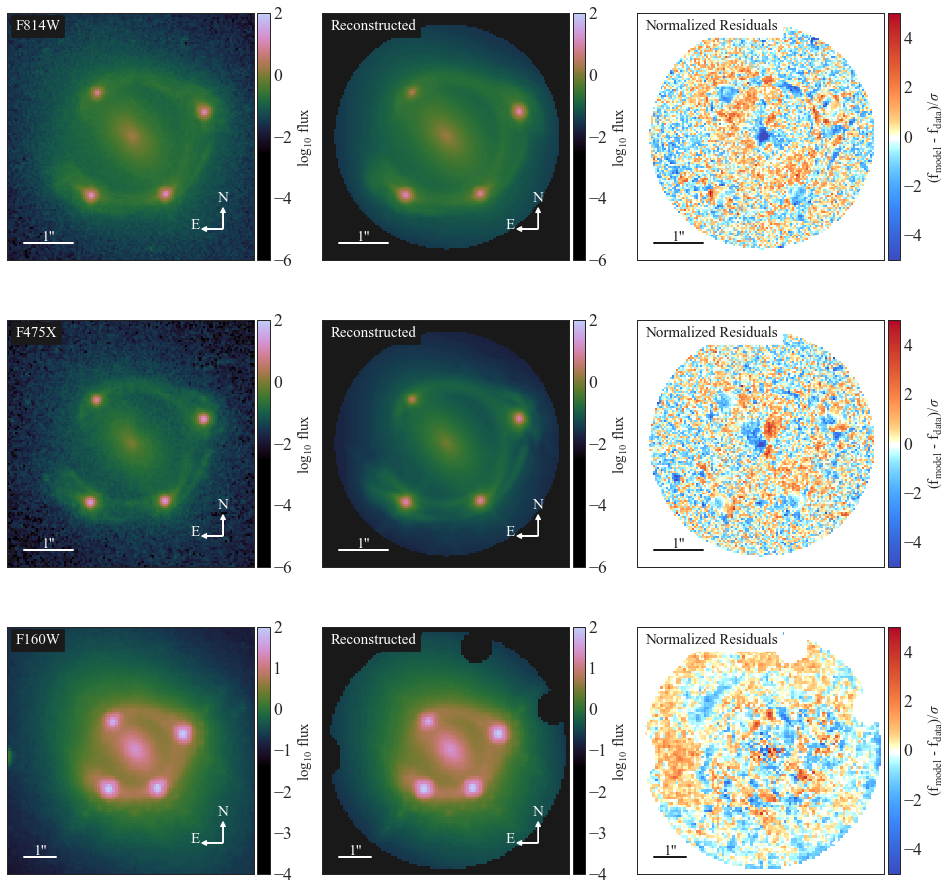

In [18]:
lens_plot = ModelPlot(multi_band_list_out, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string=cmap,
                    likelihood_mask_list=kwargs_likelihood['image_likelihood_mask_list'],
                    multi_band_type='multi-linear'#, source_marg=True, linear_prior=[1e5, 1e5, 1e5]
                    )

f, axes = plt.subplots(3, 3, figsize=(16, 16), sharex=False, sharey=False)

lens_plot.data_plot(ax=axes[0, 0], band_index=0, v_max= 2, v_min=-6, text='F814W')
lens_plot.data_plot(ax=axes[1, 0], band_index=1, v_max= 2, v_min=-6, text='F475X')
lens_plot.data_plot(ax=axes[2, 0], band_index=2, v_max= 2, v_min=-4, text='F160W')

lens_plot.model_plot(ax=axes[0, 1], band_index=0, v_max= 2, v_min=-6)
lens_plot.model_plot(ax=axes[1, 1], band_index=1, v_max= 2, v_min=-6)
lens_plot.model_plot(ax=axes[2, 1], band_index=2, v_max= 2, v_min=-4)

lens_plot.normalized_residual_plot(ax=axes[0, 2], band_index=0, v_max=5, v_min=-5, cmap=msh_cmap)
lens_plot.normalized_residual_plot(ax=axes[1, 2], band_index=1, v_max=5, v_min=-5, cmap=msh_cmap)
lens_plot.normalized_residual_plot(ax=axes[2, 2], band_index=2, v_max=5, v_min=-5, cmap=msh_cmap)

plt.show()

-1.126796656907366 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  1.2539467225658636
reduced chi^2 of data  1 =  1.2121085281061874
reduced chi^2 of data  2 =  0.7989607809700906


/Users/ajshajib/Dropbox/PyCharm Projects/lenstronomy/lenstronomy/Plots/chain_plot.py:119: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(psf_in), origin='lower', **kwargs)
/Users/ajshajib/Dropbox/PyCharm Projects/lenstronomy/lenstronomy/Plots/chain_plot.py:133: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(psf_out), origin='lower', **kwargs)
/Users/ajshajib/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


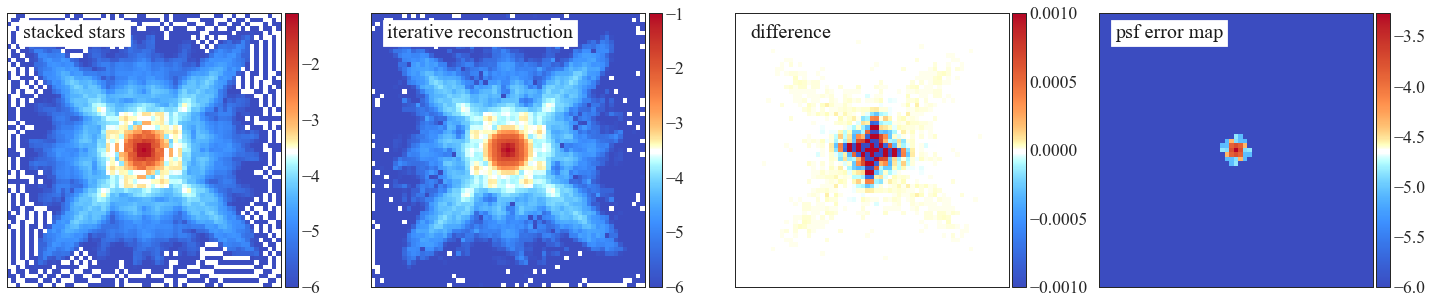

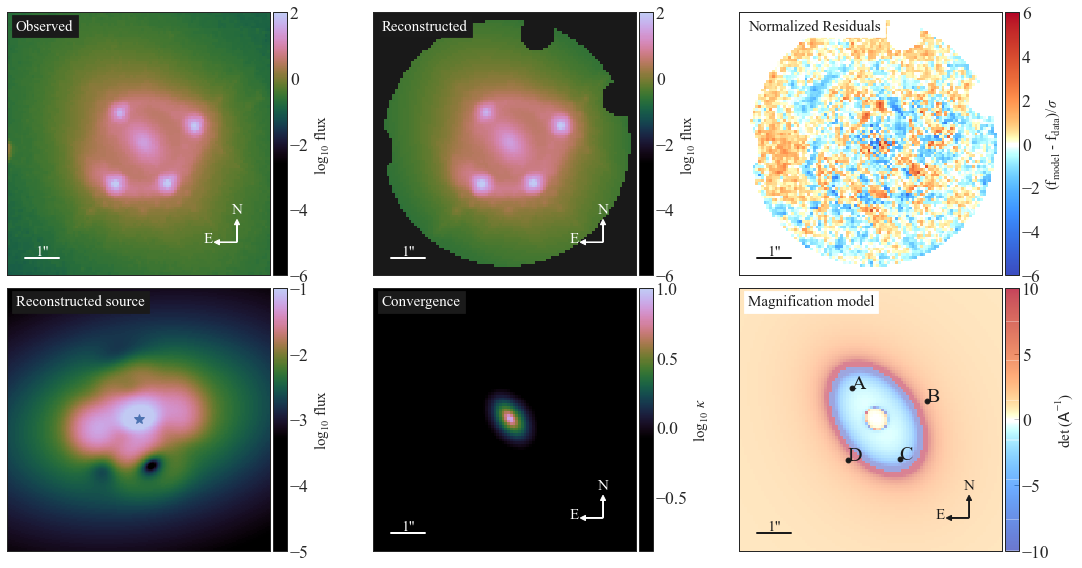

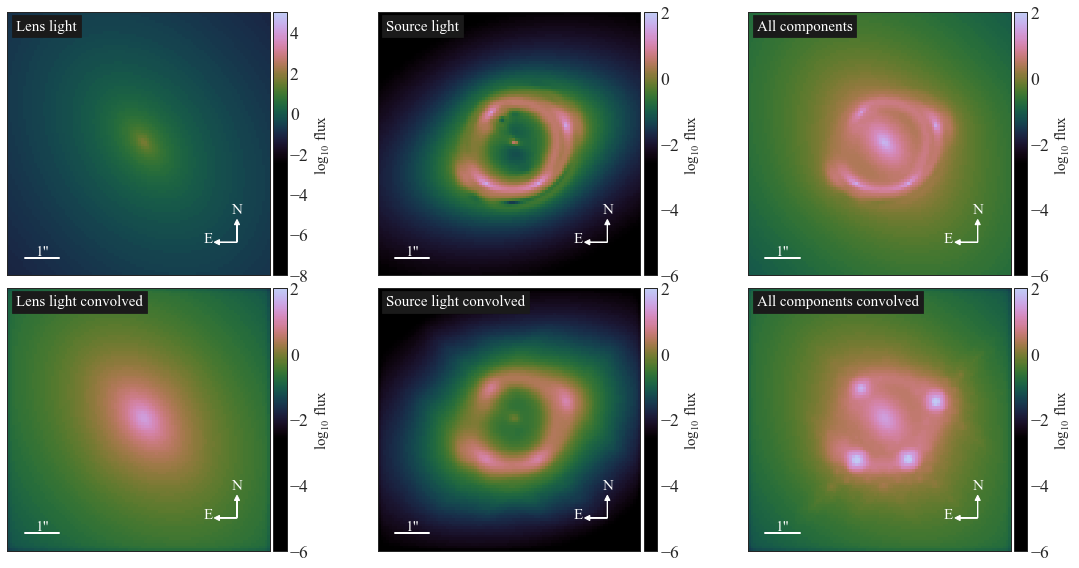

lens [{'Rs': 27.058305415063842, 'alpha_Rs': 1.3502786764869776, 'e1': 0.012275068092616923, 'e2': -0.07434101828830934, 'center_x': -0.2067103619750339, 'center_y': -0.042544112053174175}, {'gamma1': 0.03638185325230765, 'gamma2': -0.10422653924379667, 'ra_0': 0, 'dec_0': 0}, {'alpha_1': 1.012704170250425, 'ratio12': 0.891245106429113, 'ratio13': 22.07875997757515, 'w_c1': 0.06474053539351124, 'w_t1': 0.5190732648229625, 'e11': -0.07479895873345355, 'e21': 0.2744955484211773, 'w_c2': 0.27621038309979434, 'w_t2': 4.163117181050091, 'e12': -0.03880639302873714, 'e22': 0.11142291886108721, 'w_c3': 2.161773351273341, 'w_t3': 2.2822886316437874, 'e13': -0.07124347981703802, 'e23': 0.3176052261618026, 'center_x': -0.002660927210940761, 'center_y': -0.006623201078721599}] 

 source [{'amp': 63.2685548157842, 'R_sersic': 0.1699920996761902, 'n_sersic': 6.3496874531001595, 'e1': 0.22771487958910708, 'e2': -0.08637993082614477, 'center_x': -0.1525919658884866, 'center_y': -0.10354796971622099},

In [19]:
# band index to plot the model breakdown, 0: F814W, 1: F475X, 2: F160W
band_i = 2

lensPlot = ModelPlot(multi_band_list_out, kwargs_model, kwargs_result, 
                     arrow_size=0.02, cmap_string=cmap,
                    likelihood_mask_list=mask_list[0], #kwargs_likelihood['image_likelihood_mask_list'],
                    multi_band_type='multi-linear'
                    )

kwargs_psf = multi_band_list_out[band_i][1]
f, axes = chain_plot.psf_iteration_compare(kwargs_psf, vmin=-6, cmap=msh_cmap)
f.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

lensPlot.data_plot(ax=axes[0,0], band_index=band_i, v_min=-6, v_max=2) 
lensPlot.model_plot(ax=axes[0,1], band_index=band_i, v_min=-6, v_max=2) 
lensPlot.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6, band_index=band_i, cmap=msh_cmap)
lensPlot.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=200, band_index=band_i, v_min=-5, v_max=-1) 
lensPlot.convergence_plot(ax=axes[1, 1], v_max=1, band_index=band_i)
lensPlot.magnification_plot(ax=axes[1, 2], cmap=msh_cmap, band_index=band_i)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

lensPlot.decomposition_plot(ax=axes[0,0], text='Lens light', lens_light_add=True, unconvolved=True, cmap=cmap, band_index=band_i, v_min=-8, v_max=5) 
lensPlot.decomposition_plot(ax=axes[1,0], text='Lens light convolved', lens_light_add=True, band_index=band_i, v_min=-6, v_max=2) 
lensPlot.decomposition_plot(ax=axes[0,1], text='Source light', source_add=True, unconvolved=True, band_index=band_i, v_min=-6, v_max=2) 
lensPlot.decomposition_plot(ax=axes[1,1], text='Source light convolved', source_add=True, band_index=band_i, v_min=-6, v_max=2) 
lensPlot.decomposition_plot(ax=axes[0,2], text='All components', source_add=True, lens_light_add=True, unconvolved=True, band_index=band_i, v_min=-6, v_max=2) 
lensPlot.decomposition_plot(ax=axes[1,2], text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True, band_index=band_i, v_min=-6, v_max=2) 
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()

lens_result, source_result, lens_light_result, ps_result = kwargs_result['kwargs_lens'], kwargs_result['kwargs_source'], kwargs_result['kwargs_lens_light'], kwargs_result['kwargs_ps']
print('lens', lens_result, "\n\n source", source_result, '\n\n lens light', lens_light_result, '\n\n ps', ps_result)


/Users/ajshajib/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  
/Users/ajshajib/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  from ipykernel import kernelapp as app


N_step: 3000, N_walkers: 432, N_params: 54
Rs_lens0 27.9178 ± 1.5989
gamma1_lens1 0.0363 ± 0.0025
gamma2_lens1 -0.1055 ± 0.0014
alpha_1_lens2 1.0176 ± 0.0145
R_sersic_source_light0 0.1621 ± 0.0057
n_sersic_source_light0 5.7644 ± 0.2424
e1_source_light0 0.2070 ± 0.0130
e2_source_light0 -0.0612 ± 0.0147
beta_source_light1 0.0929 ± 0.0014
R_sersic_source_light2 0.1575 ± 0.0058
n_sersic_source_light2 1.7704 ± 0.2346
beta_source_light3 0.0955 ± 0.0025
R_sersic_source_light4 0.4823 ± 0.0084
n_sersic_source_light4 4.4412 ± 0.4034
beta_source_light5 0.1428 ± 0.0027
R_sersic_lens_light0 0.7460 ± 0.0283
n_sersic_lens_light0 1.8310 ± 0.0330
e1_lens_light0 -0.0602 ± 0.0029
e2_lens_light0 0.2624 ± 0.0038
center_x_lens_light0 -0.0029 ± 0.0004
center_y_lens_light0 -0.0072 ± 0.0005
R_sersic_lens_light1 3.1692 ± 0.0232
n_sersic_lens_light1 1.2402 ± 0.0907
e1_lens_light1 0.0552 ± 0.0093
e2_lens_light1 0.0461 ± 0.0204
R_sersic_lens_light2 5.8564 ± 0.0246
n_sersic_lens_light2 0.8334 ± 0.2087
e1_lens_light

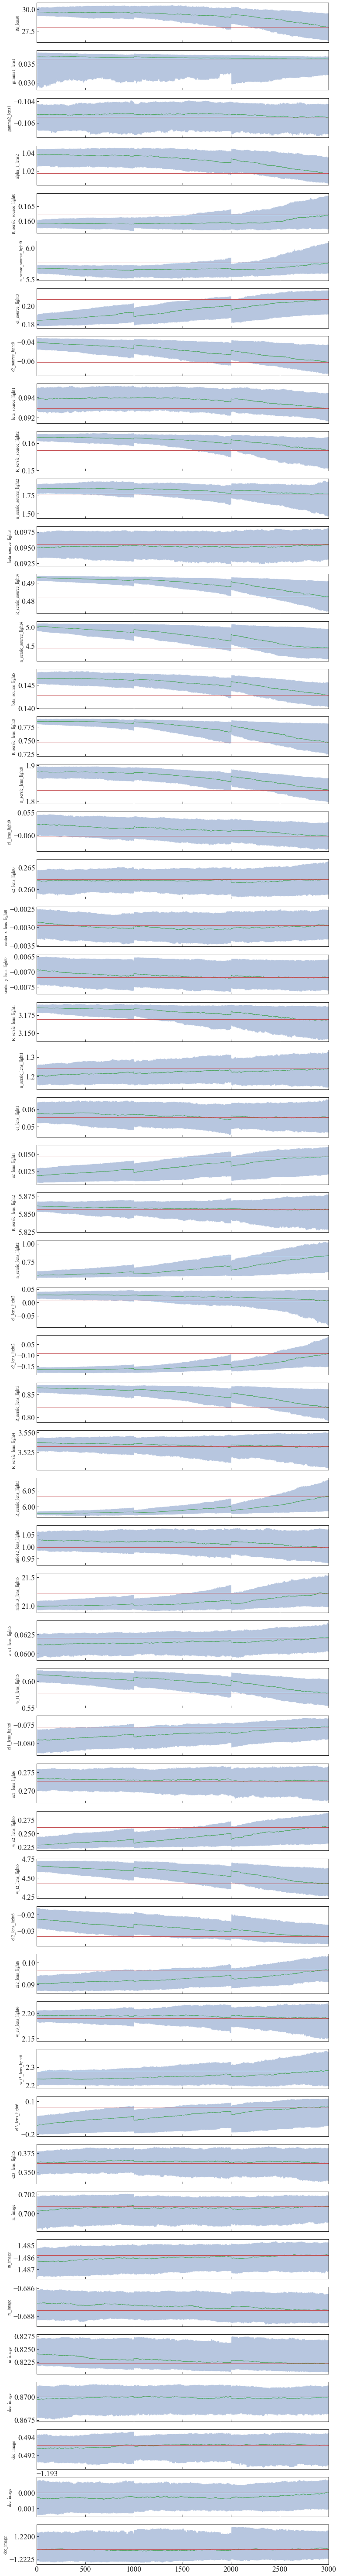

In [20]:
samples_mcmc = []

if fit_output[-1][0] != 'PSO':
    # if MCMC chain was broken in the chunks, we join the chunks to make the full chain
    mcmc_repeat = 3
      
    for k in range(len(fit_output)-mcmc_repeat, len(fit_output)):
        if samples_mcmc == []:
            samples_mcmc = fit_output[k][1]
        else:
            samples_mcmc = np.vstack((samples_mcmc, fit_output[k][1]))

        param_mcmc = fit_output[k][2]
    
if not samples_mcmc == []:
    n_params = samples_mcmc.shape[1]

    n_walkers = 8 * n_params
    n_step = int(samples_mcmc.shape[0] / n_walkers)

    print('N_step: {}, N_walkers: {}, N_params: {}'.format(n_step, n_walkers, n_params))

    chain = np.empty((n_walkers, n_step, n_params))

    for i in np.arange(n_params):
        samples = samples_mcmc[:, i].T
        chain[:,:,i] = samples.reshape((n_step, n_walkers)).T

    mean_pos = np.zeros((n_params, n_step))
    median_pos = np.zeros((n_params, n_step))
    std_pos = np.zeros((n_params, n_step))
    q16_pos = np.zeros((n_params, n_step))
    q84_pos = np.zeros((n_params, n_step))

    for i in np.arange(n_params):
        for j in np.arange(n_step):
            mean_pos[i][j] = np.mean(chain[:, j, i])
            median_pos[i][j] = np.median(chain[:, j, i])
            std_pos[i][j] = np.std(chain[:, j, i])
            q16_pos[i][j] = np.percentile(chain[:, j, i], 16.)
            q84_pos[i][j] = np.percentile(chain[:, j, i], 84.)

    fig, ax = plt.subplots(n_params, sharex=True, figsize=(8, 6))

    burnin = -1
    last = n_step

    medians = []

    param_values = [median_pos[0][last-1], (q84_pos[0][last-1]-q16_pos[0][last-1])/2,
                    median_pos[1][last-1], (q84_pos[1][last-1]-q16_pos[1][last-1])/2]

    for i in range(n_params):
        print(param_mcmc[i], '{:.4f} ± {:.4f}'.format(median_pos[i][last-1], (q84_pos[i][last-1]-q16_pos[i][last-1])/2))

        ax[i].plot(median_pos[i][:last], c='g')
        ax[i].axhline(np.median(median_pos[i][burnin:last]), c='r', lw=1)
        ax[i].fill_between(np.arange(last), q84_pos[i][:last], q16_pos[i][:last], alpha=0.4)
        ax[i].set_ylabel(param_mcmc[i], fontsize=10)
        ax[i].set_xlim(0, last)

        medians.append(np.median(median_pos[i][burnin:last]))

    if True:
        fig.set_size_inches((12., 2*len(param_mcmc)))
        plt.show()